<a href="https://colab.research.google.com/github/JRamos84/deteccion_fraude/blob/main/Data_story_telling_Ramos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Importar librerrias
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import os
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
import os

%matplotlib inline

In [2]:
# Create a directory to save the visualizations
folder_name = 'star_plots'                     # directory name
os.makedirs(folder_name, exist_ok=True)        # Create directory if not exisiting
base_dir = f'/content/{folder_name}/'          # Store the path of this directory as base_dir to use it further

# Sección nueva

In [3]:
#Función que calcula los rangos cuantiles
def calculo_quantile(data,columna):
  Q1 = data[columna].quantile(0.25)
  # Calcular el tercer cuartil (Q3)
  Q3 = data[columna].quantile(0.75)
  # Calcular el rango intercuartil (IQR)
  IQR = Q3 - Q1
  # Calcular los límites para identificar valores atípicos
  limite_inferior = Q1 - 1.5 * IQR
  limite_superior = Q3 + 1.5 * IQR

  print("Primer Cuartil (Q1):", Q1)
  print("Tercer Cuartil (Q3):", Q3)
  print("Rango Intercuartil (IQR):", IQR)
  print("Límite Inferior:", limite_inferior)
  print("Límite Superior:", limite_superior)
  return limite_superior

In [4]:

### Gráfica histograma con boxplot
def grafica_histo_boxplot(data, columna,xlabel_col, caption,kde=True):
    fig, axs = plt.subplots(2, 2, tight_layout=True, figsize=(12, 8), gridspec_kw={"height_ratios": (.15, .85)})

    data_categoria_no = data[data['isFraud'] == 0][columna]
    sns.boxplot(x=data_categoria_no, ax=axs[0][0])
    sns.histplot(data_categoria_no, bins=30, color='tab:blue', edgecolor="white", linewidth=0.7, label='No', kde=kde, ax=axs[1][0])
    axs[1][0].set_ylabel('Número de Fraudes')
    axs[1][0].set_xlabel(xlabel_col)
    axs[1][0].set_title(columna)
    axs[1][0].legend(title='Es Fraude')

    data_categoria_si = data[data['isFraud'] == 1][columna]
    sns.boxplot(x=data_categoria_si, ax=axs[0][1], color='tab:red')
    sns.histplot(data_categoria_si, bins=30, color='tab:red', edgecolor="white", linewidth=0.7, label='Sí', kde=kde, ax=axs[1][1])
    axs[1][1].set_ylabel('Número de Fraudes')
    axs[1][1].set_xlabel(xlabel_col)
    axs[1][1].set_title(columna)
    axs[1][1].legend(title='Es Fraude')

    # Agregar un caption
    figtext_params = dict(x=0.5, y=0.01, ha="center", va="top", fontsize=12)
    figtext_text = caption
    fig.text(**figtext_params, s=figtext_text)



In [5]:
##Realiza las permutaciones para el test A/B
import random
random.seed(42)
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[list(idx_B)][x==1].shape[0]/x.loc[list(idx_B)].shape[0] - x.loc[list(idx_A)][x==1].shape[0]/x.loc[list(idx_A)].shape[0]


In [6]:
def n_estimators_error(md):
    model = RandomForestClassifier(n_estimators=100, random_state=42,max_depth=md)
    model.fit(X_train, y_train)
    train_acc = 1 - model.score(X_train, y_train)
    val_acc = 1 - model.score(X_test, y_test)
    return {'Max Depth': md, 'Training Error': train_acc, 'Validation Error': val_acc}

# **Detección de Fraude**

> Agregar bloque entrecomillado

> Agregar bloque entrecomillado





*¿Se puede detectar fraude en las transacciones de los clientes?*

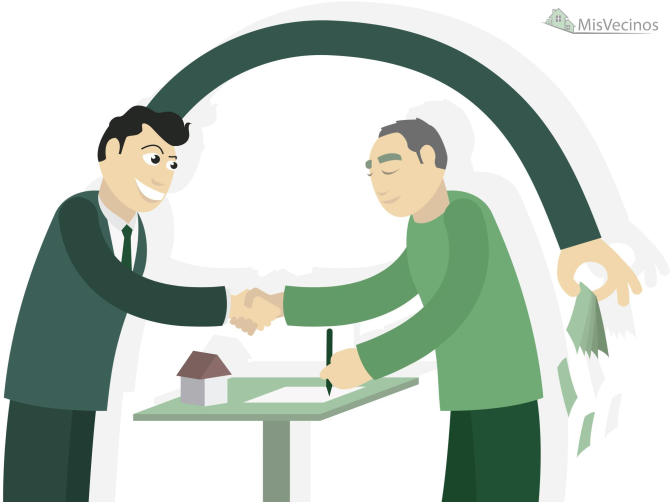


## **1. Objetivo General**

A lo largo de la historia de la civilización, el fenómeno del fraude ha desempeñado un papel crucial en cualquier transacción comercial o intercambio de mercancías. La importancia de abordar este tema de manera efectiva radica en su impacto directo en el éxito de ambas partes involucradas. En este contexto, el análisis de datos se presenta como una herramienta fundamental para comprender, prevenir y mitigar el riesgo de fraude, ofreciendo así un enfoque informado y proactivo en la gestión de transacciones comerciales. Este análisis no solo busca salvaguardar la integridad de las operaciones, sino también contribuir a un entorno empresarial más seguro y confiable.

## **2. Conjuntos de Datos**

El corpus de datos empleado en este análisis se obtuvo de Kaggle, específicamente como parte de uno de los desafíos planteados por la plataforma en el ámbito de la detección de fraudes. Es relevante resaltar que Kaggle atribuye la provisión de estos datos a Vesta Corporation, una destacada pionera en soluciones de pago garantizadas para el comercio electrónico.

### **2.1 Organización de los Datos**
El conjunto de datos consta de dos tablas fundamentales. En primer lugar, contamos con la "Tabla de Transacciones", que ofrece información detallada sobre cada transacción realizada. En segundo lugar, encontramos la "Tabla de Identidad", la cual proporciona datos cruciales relacionados con la conexión de red, incluyendo información como la dirección IP, proveedor de servicios de Internet (ISP), el uso de proxy, entre otros.

Esta estructura dual del conjunto de datos permite una comprensión integral de las transacciones al incorporar tanto los detalles transaccionales como la identidad digital asociada, enriqueciendo así el análisis y la interpretación de la información.






## **3. Definición de Temática**

En nuestro objetivo de desarrollar un sistema de detección de fraude temprana con el fin de mejorar la experiencia tanto del cliente como de las empresas involucradas en las transacciones, es esencial identificar las características más relevantes que permitan distinguir entre transacciones normales y fraudulentas.

Algunas de las características clave que podrían ser prioritarias en este análisis incluyen:

**1. Patrones de Comportamiento:**

- Frecuencia y horarios típicos de transacciones del usuario.
- Cambios inusuales en el comportamiento de transacciones, como volúmenes anómalos o ubicaciones atípicas.

**2. Características de la Identidad Digital:**

- Anomalías en direcciones IP, cambios frecuentes de dispositivos o ubicaciones.
- Inconsistencias en la información de firma digital, como versiones de navegador o sistemas operativos inesperados.

**3. Historial de Transacciones:**

- Comparación de patrones de compra habituales con la transacción actual.
- Evaluación de la coherencia en el historial de transacciones del usuario.

**4. Datos de Autenticación:**

- Fallos recurrentes o intentos repetidos de autenticación.
- Detección de actividad sospechosa durante el proceso de inicio de sesión.

**5. Características Financieras:**

- Transacciones de grandes cantidades o patrones de gastos inusuales.
- Cambios abruptos en el comportamiento financiero del usuario.

**6. Análisis de Redes:**

- Relaciones inusuales entre diferentes cuentas o usuarios.
- Actividad sospechosa en redes de conexión o uso de proxies.

**7. Características Temporales:**

- Detección de transacciones rápidas o simultáneas desde ubicaciones geográficas distantes.

**8. Modelos de Machine Learning:**

- Utilización de algoritmos de aprendizaje automático para identificar patrones no lineales y complejas relaciones entre variables.

Es fundamental realizar un análisis exhaustivo y adaptativo de estas características, ya que los métodos de fraude pueden evolucionar con el tiempo. La combinación de estas características puede proporcionar una visión integral para el desarrollo de un sistema efectivo de detección de fraude temprana.

[Enlace al conjunto de datos](https://www.kaggle.com/competitions/ieee-fraud-detection/overview)


## **4. Descarga del dataset para evaluación**

Los archivos se dividen en conjuntos de datos de entrenamiento y prueba. Es crucial tener en cuenta que el conjunto de datos de entrenamiento es considerablemente extenso, lo que podría afectar la eficiencia en esta fase inicial del análisis. Por lo tanto, optaremos por trabajar con una fracción representativa de los datos de entrenamiento en esta etapa inicial. En el análisis final, contaremos con la totalidad del conjunto de datos de entrenamiento para obtener una visión completa y detallada.

In [7]:
## Importamos las librerias a usar
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/cursos-analisis-datos/data-science/proyecto/propuestas/propuesta1/ieee-fraud-detection'

Mounted at /content/drive


In [8]:
## Lista de los archivos descargados
!ls -lh {data_dir}

total 1.3G
-rw------- 1 root root 5.8M Dec 12  2019 sample_submission.csv
-rw------- 1 root root  25M Dec 12  2019 test_identity.csv
-rw------- 1 root root 585M Dec 12  2019 test_transaction.csv
-rw------- 1 root root  26M Dec 12  2019 train_identity.csv
-rw------- 1 root root 652M Dec 12  2019 train_transaction.csv


In [9]:
# Numero de registro de cada archivo
!wc -l {data_dir}/train_transaction.csv

590541 /content/drive/MyDrive/cursos-analisis-datos/data-science/proyecto/propuestas/propuesta1/ieee-fraud-detection/train_transaction.csv


In [10]:
# Numero de registro de cada archivo
!wc -l {data_dir}/train_identity.csv

144234 /content/drive/MyDrive/cursos-analisis-datos/data-science/proyecto/propuestas/propuesta1/ieee-fraud-detection/train_identity.csv


In [11]:
# Numero de registro de cada archivo
!wc -l {data_dir}/test_transaction.csv

506692 /content/drive/MyDrive/cursos-analisis-datos/data-science/proyecto/propuestas/propuesta1/ieee-fraud-detection/test_transaction.csv


In [12]:
# Numero de registro de cada archivo
!wc -l {data_dir}/test_identity.csv

141908 /content/drive/MyDrive/cursos-analisis-datos/data-science/proyecto/propuestas/propuesta1/ieee-fraud-detection/test_identity.csv


**Cantidad de registros por archivo**

| tipo de datos | N° de Registros |
| ------------ | ------------ |
| train_transaction     | 590541|
| train_indentity     | 144231|
| test_transaction     | 506692|
| test_indentity     | 141908|

Los datos de entrenamientos son más de un millon de registro, por lo tanto se tomo una fracción de los registro de entrenamiento para este trabajo.

### **4.1 Características de las Tablas**

Los datos se dividen en dos archivos: `identity` y `transaction`, unidos por `TransactionID`.

### **Características Categóricas - Tabla Transaction**

- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

### **Características Categóricas - Tabla Identity**

Las variables en esta tabla incluyen información de identidad, abarcando detalles de la conexión de red (IP, ISP, Proxy, etc.) y la firma digital (UA/navegador/sistema operativo/versión, etc.) asociada con las transacciones. Estos datos son recopilados por el sistema de protección contra fraudes de Vesta y socios de seguridad digital. (Los nombres de los campos están enmascarados y no se proporcionará un diccionario emparejado por razones de privacidad y acuerdo contractual).

- DeviceType
- DeviceInfo
- id_12 - id_38

**Realizaremos una fusión de ambas tablas para construir un único marco de datos. Además, procederemos a seleccionar una porción específica de este marco de datos, ya que, en esta primera fase del análisis, no es necesario utilizar todos los registros. Al final, emplearemos la totalidad de los datos.**


In [13]:
select_col_transaction = 'TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9'.split(',')
select_col_identity = 'TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo'.split(',')
select_col_transaction_test = 'TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9'.split(',')
select_col_identity_test ='TransactionID,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-18,id-19,id-20,id-21,id-22,id-23,id-24,id-25,id-26,id-27,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo'.split(',')

In [14]:
seed = 42
df_transaction_train = pd.read_csv(data_dir + '/train_transaction.csv',usecols=select_col_transaction)
df_identity_train = pd.read_csv(data_dir + '/train_identity.csv',usecols=select_col_identity)
dataset = pd.merge(df_transaction_train, df_identity_train, on='TransactionID', how='left').sample(frac=0.1, random_state=seed)
dataset.info()


<class 'pandas.core.frame.DataFrame'>
Index: 59054 entries, 470624 to 579244
Data columns (total 95 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TransactionID   59054 non-null  int64  
 1   isFraud         59054 non-null  int64  
 2   TransactionDT   59054 non-null  int64  
 3   TransactionAmt  59054 non-null  float64
 4   ProductCD       59054 non-null  object 
 5   card1           59054 non-null  int64  
 6   card2           58150 non-null  float64
 7   card3           58897 non-null  float64
 8   card4           58895 non-null  object 
 9   card5           58603 non-null  float64
 10  card6           58896 non-null  object 
 11  addr1           52513 non-null  float64
 12  addr2           52513 non-null  float64
 13  dist1           23775 non-null  float64
 14  dist2           3698 non-null   float64
 15  P_emaildomain   49496 non-null  object 
 16  R_emaildomain   13726 non-null  object 
 17  C1              59054 non-null

In [15]:
dataset.head(5)

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
470624        3457624        0       12153579         724.000         W   
565820        3552820        0       15005886         108.500         W   
284083        3271083        0        6970178          47.950         W   
239689        3226689        0        5673658         100.599         C   
281855        3268855        0        6886780         107.950         W   

        card1  card2  card3       card4  card5  ... id_31  id_32  id_33  \
470624   7826  481.0  150.0  mastercard  224.0  ...   NaN    NaN    NaN   
565820  12544  321.0  150.0        visa  226.0  ...   NaN    NaN    NaN   
284083   9400  111.0  150.0  mastercard  224.0  ...   NaN    NaN    NaN   
239689  15885  545.0  185.0        visa  138.0  ...   NaN    NaN    NaN   
281855  15497  490.0  150.0        visa  226.0  ...   NaN    NaN    NaN   

        id_34  id_35 id_36 id_37  id_38  DeviceType  DeviceInfo  
470624    NaN    NaN   NaN   NaN    NaN         NaN         NaN  
565820    NaN    NaN   NaN   NaN    NaN         NaN         NaN  
284083    NaN    NaN   NaN   NaN    NaN         NaN         NaN  
239689    NaN    NaN   NaN   NaN    NaN         NaN         NaN  
281855    NaN    NaN   NaN   NaN    NaN         NaN         NaN  

[5 rows x 95 columns]

### **4.2 Consideraciones Iniciales**
En la fase inicial de nuestro análisis, nos enfrentamos a una abrumadora cantidad de columnas. Con el objetivo de simplificar y focalizarnos en esta etapa inicial, buscaremos reducir el conjunto de columnas al máximo posible.

#### Características Iniciales para el Análisis de Primera Etapa
1. **TransactionDT:** Representa un delta de tiempo desde un punto de referencia.
2. **TransactionAMT:** Indica la cantidad en USD para el pago de la transacción.
3. **ProductCD:** Código del producto.
4. **addr:** Dirección.
5. **dist:** Distancia.
6. **P_ and (R__):** Dominio de correo electrónico del comprador y del destinatario.
7. **deviceType**
8. **DeviceInfo**

Las siguientes características no se incluirán en esta fase inicial:
- **C1-C14:** Recuento, como la cantidad de direcciones asociadas a la tarjeta de pago, entre otros. El significado real está enmascarado.
- **D1-D15:** Timedelta, como los días entre la transacción anterior, etc.
- **M1-M9:** Coincidencias, como los nombres en la tarjeta y la dirección, etc.
- **Vxxx:** Características ricas desarrolladas por Vesta, que incluyen ranking, conteo y relaciones con otras entidades.

id_12 - id_38





In [16]:
dataset.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9', 'id_01', 'id_02', 'id_03', 'id_04',
       'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12',
       'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20',
       'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28',
       'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36',
       'id_37', 'id_38', 'DeviceType', 'DeviceInfo'],
      dtype='object')

In [17]:
## Armamos un nuevo dataset con menos cantidad de columnas
df_train_1 = dataset[['isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD','addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'DeviceType', 'DeviceInfo']].copy()

## **5. Limpieza de Datos**

### **5.1 Tipo de datos**

In [18]:

df_train,df_test = train_test_split(df_train_1,test_size=0.2,stratify=df_train_1['isFraud'])

In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47243 entries, 542017 to 166626
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   isFraud         47243 non-null  int64  
 1   TransactionDT   47243 non-null  int64  
 2   TransactionAmt  47243 non-null  float64
 3   ProductCD       47243 non-null  object 
 4   addr1           42020 non-null  float64
 5   addr2           42020 non-null  float64
 6   dist1           19019 non-null  float64
 7   dist2           2953 non-null   float64
 8   P_emaildomain   39610 non-null  object 
 9   R_emaildomain   10930 non-null  object 
 10  DeviceType      11188 non-null  object 
 11  DeviceInfo      9391 non-null   object 
dtypes: float64(5), int64(2), object(5)
memory usage: 4.7+ MB


In [20]:
for columna in df_train.columns:
    print(f"Columna: {columna}, el número de variables es: {df_train[columna].nunique()}")


Columna: isFraud, el número de variables es: 2
Columna: TransactionDT, el número de variables es: 47141
Columna: TransactionAmt, el número de variables es: 5027
Columna: ProductCD, el número de variables es: 5
Columna: addr1, el número de variables es: 122
Columna: addr2, el número de variables es: 27
Columna: dist1, el número de variables es: 1295
Columna: dist2, el número de variables es: 589
Columna: P_emaildomain, el número de variables es: 59
Columna: R_emaildomain, el número de variables es: 57
Columna: DeviceType, el número de variables es: 2
Columna: DeviceInfo, el número de variables es: 718


### **5.2 Valores Nulos**

#### **5.2.1 Identificación de valores nulos**

In [21]:
# Another way: using the isna() method
for column in df_train.columns:
    num_nulls = df_train[column].isna().sum()
    print(f'Column "{column}" has {num_nulls} nulls')

Column "isFraud" has 0 nulls
Column "TransactionDT" has 0 nulls
Column "TransactionAmt" has 0 nulls
Column "ProductCD" has 0 nulls
Column "addr1" has 5223 nulls
Column "addr2" has 5223 nulls
Column "dist1" has 28224 nulls
Column "dist2" has 44290 nulls
Column "P_emaildomain" has 7633 nulls
Column "R_emaildomain" has 36313 nulls
Column "DeviceType" has 36055 nulls
Column "DeviceInfo" has 37852 nulls


In [22]:
## Porcentaje de valores nulos
null_percentages = (df_train.isnull().sum() / len(df_train)) * 100
print(round(null_percentages,2))

isFraud            0.00
TransactionDT      0.00
TransactionAmt     0.00
ProductCD          0.00
addr1             11.06
addr2             11.06
dist1             59.74
dist2             93.75
P_emaildomain     16.16
R_emaildomain     76.86
DeviceType        76.32
DeviceInfo        80.12
dtype: float64


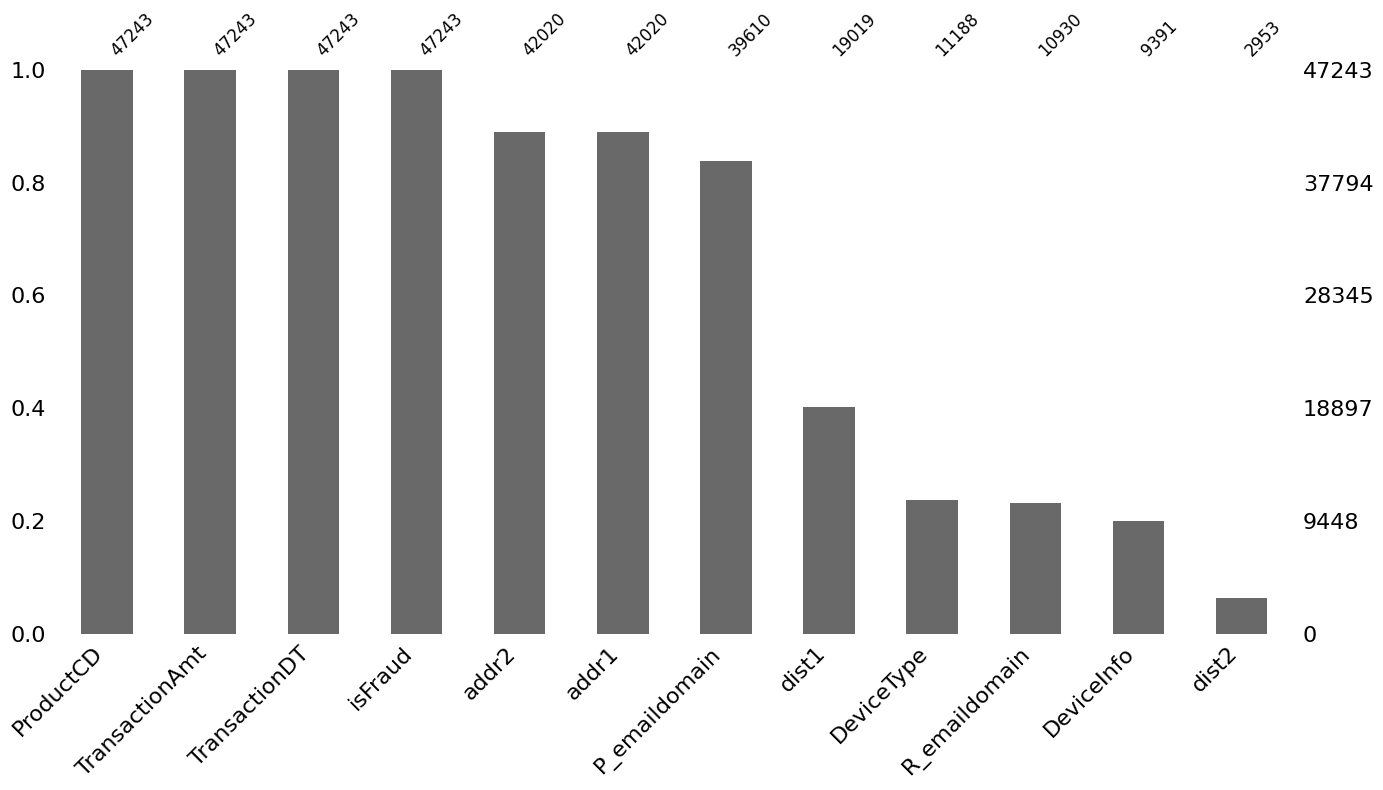

In [23]:
import matplotlib.pyplot as plt
import missingno as msno

# Crear la figura con el tamaño deseado
plt.figure(figsize=(14, 8))

# Generar el gráfico de barras de valores nulos
msno.bar(df_train, sort='descending')

# Ajustar el tamaño de las etiquetas de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Obtener la figura actual y ajustar el tamaño
fig = plt.gcf()
fig.set_size_inches(14, 8)  # Asegurarse de que el tamaño de la figura sea adecuado

# Ajustar los márgenes para evitar que las etiquetas se recorten
plt.tight_layout()

# Guardar la figura en un archivo PNG
plt.savefig(base_dir + 'nulos.png')

# Mostrar la figura
plt.show()


In [24]:
df_train.columns

Index(['isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'addr1',
       'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'DeviceType', 'DeviceInfo'],
      dtype='object')

#### En el gráfico de arriba se presenta una visualización de la cantidad de valores nulos en forma descendente. Destacan especialmente cinco atributos con una significativa cantidad de valores nulos: 'dist1', 'DeviceType', 'R_emaildomain', 'DeviceInfo' y 'dist2'. Esta distribución nos ofrece una instantánea clara de las áreas de nuestros datos que pueden requerir mayor atención y manejo especial durante el proceso de limpieza y preparación de los datos.

#### **5.2.2 Exploración visual de valores nulos**
#### A través de esta visualización, buscamos identificar posibles relaciones entre las variables que muestran valores nulos. Este análisis nos brindará información clave para tomar decisiones informadas sobre cómo abordar estas variables en nuestro proceso de análisis de datos. Identificar patrones o correlaciones entre estas variables puede proporcionar pistas importantes sobre cómo imputar los valores faltantes o si es necesario aplicar técnicas más avanzadas de manejo de datos. Este enfoque nos ayuda a maximizar la calidad y la utilidad de nuestros análisis, asegurando que nuestras decisiones estén respaldadas por una comprensión profunda de los datos subyacentes.

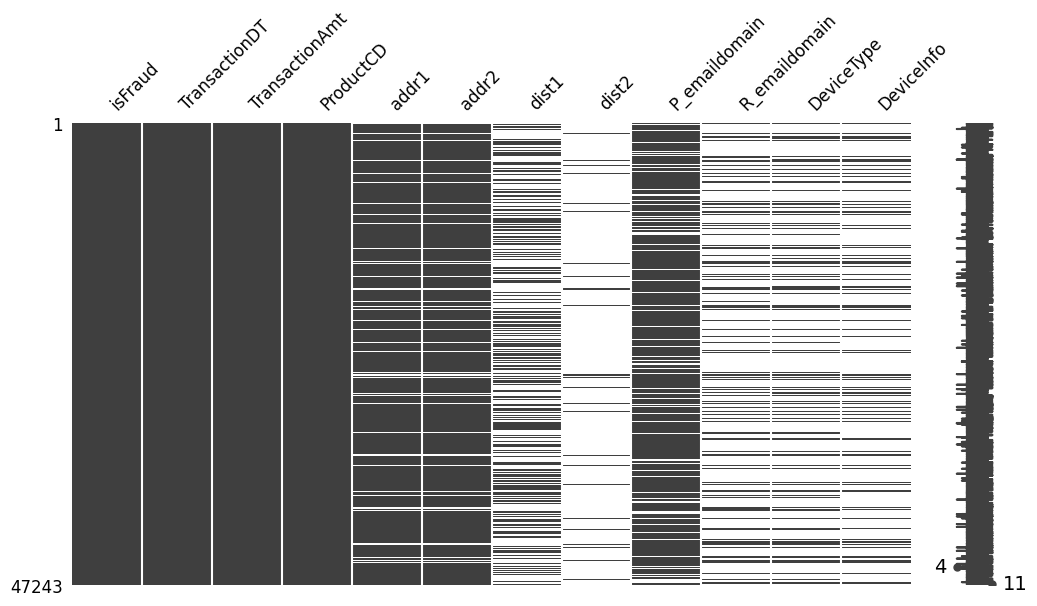

In [25]:
msno.matrix(df_train)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(12, 6)

En el gráfico de arriba se puede visualizar los datos nulos del dataset de entranamiento.

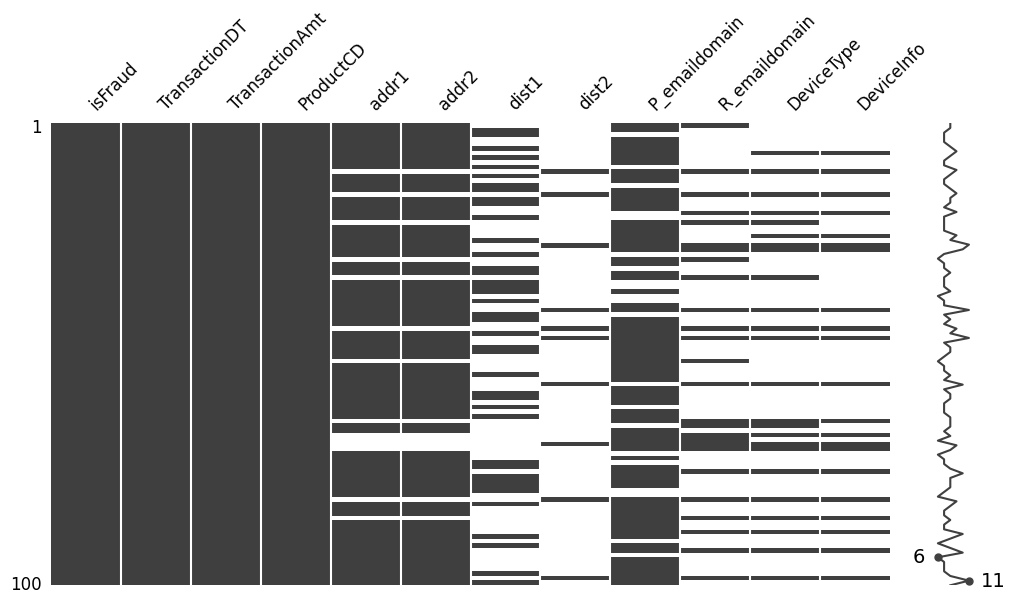

In [26]:
msno.matrix(df_train.sample(100))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(12, 6)

visualizamos los valores perdidos con una muestra de menor tamaño para tener una mejor magnitud de los valores nulos.

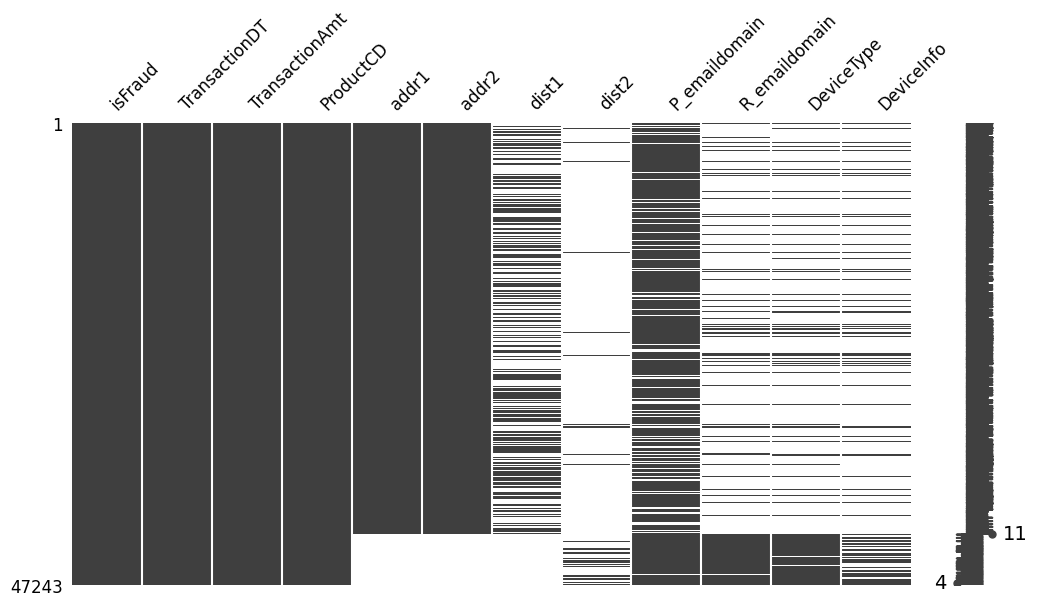

In [27]:
sorte_addr1 = df_train.sort_values('addr1')
msno.matrix(sorte_addr1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(12, 6)

Ordenamos los valores nulos con respecto "addr1", con lo que observamos "addr2" tambíen son ordenados por lo tanto se encuentra que hay una relación entre los valores nulos entre ellos.

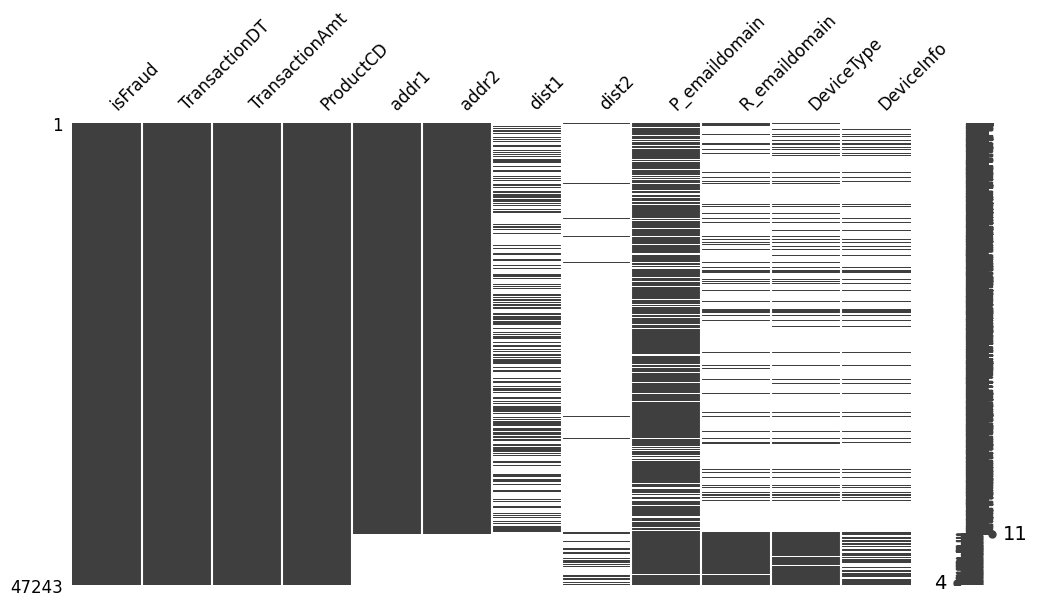

In [28]:
sorte_addr2 = df_train.sort_values('addr2')
msno.matrix(sorte_addr2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(12, 6)

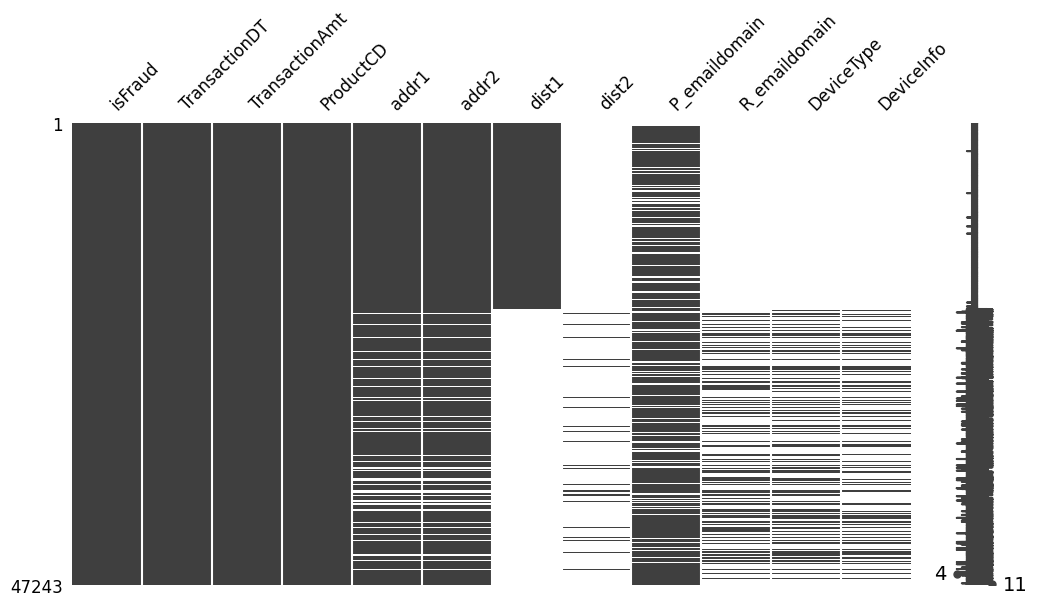

In [29]:
sorte_dist = df_train.sort_values('dist1')
msno.matrix(sorte_dist)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(12, 6)

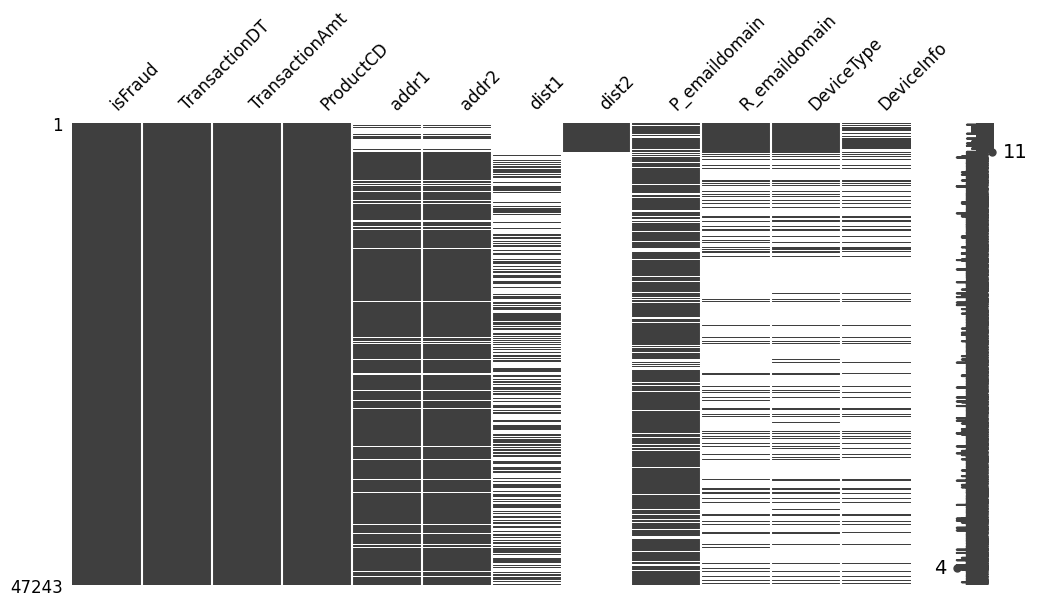

In [30]:
sorte_dist2 = df_train.sort_values('dist2')
msno.matrix(sorte_dist2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(12, 6)

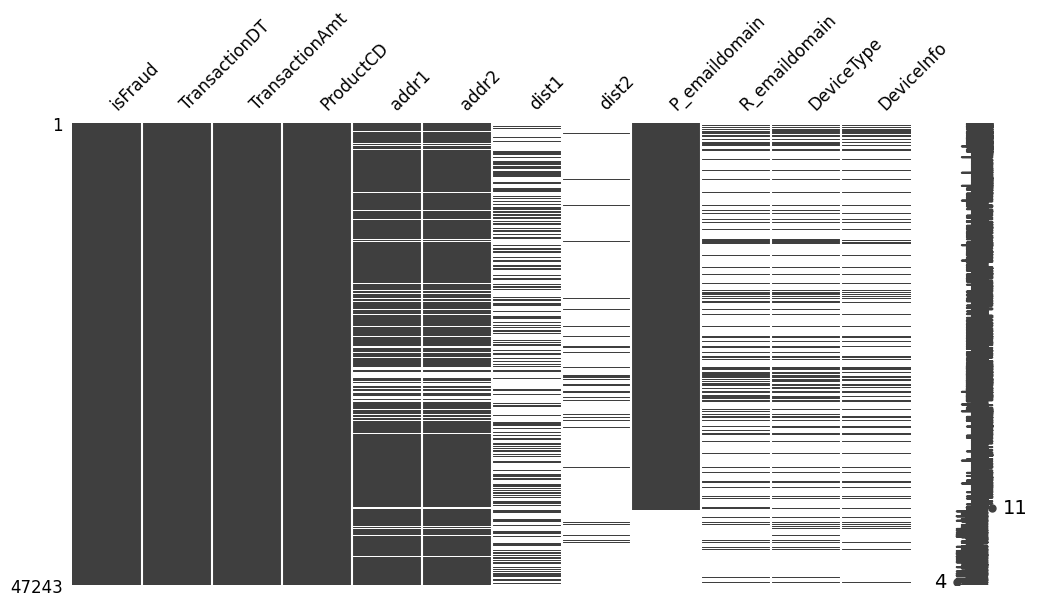

In [31]:
sorte_P_emaildomain = df_train.sort_values('P_emaildomain')
msno.matrix(sorte_P_emaildomain)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(12, 6)

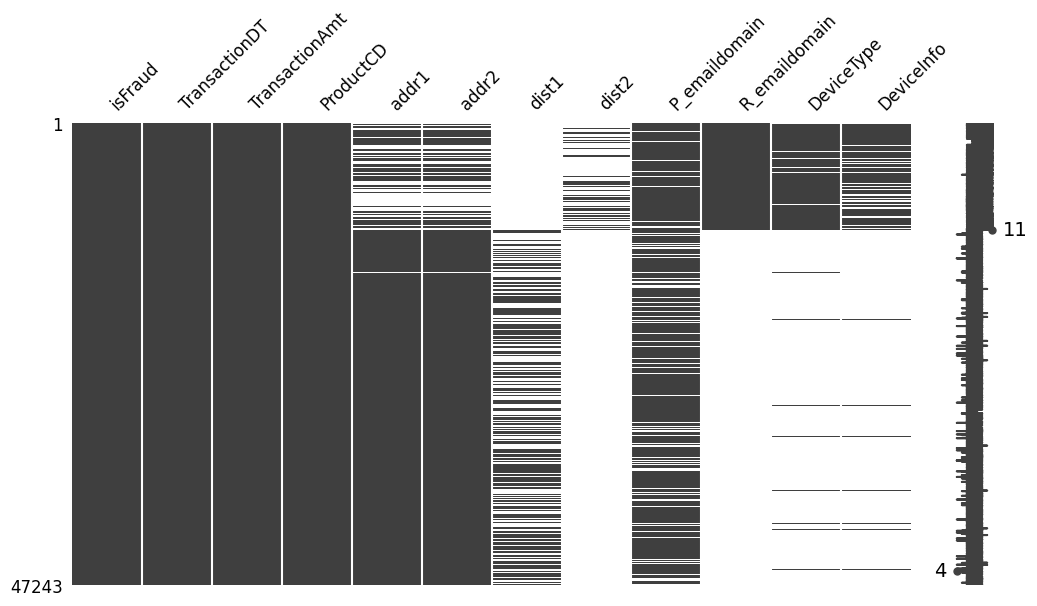

In [32]:
sorte_P_emaildomain = df_train.sort_values('R_emaildomain')
msno.matrix(sorte_P_emaildomain)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(12, 6)

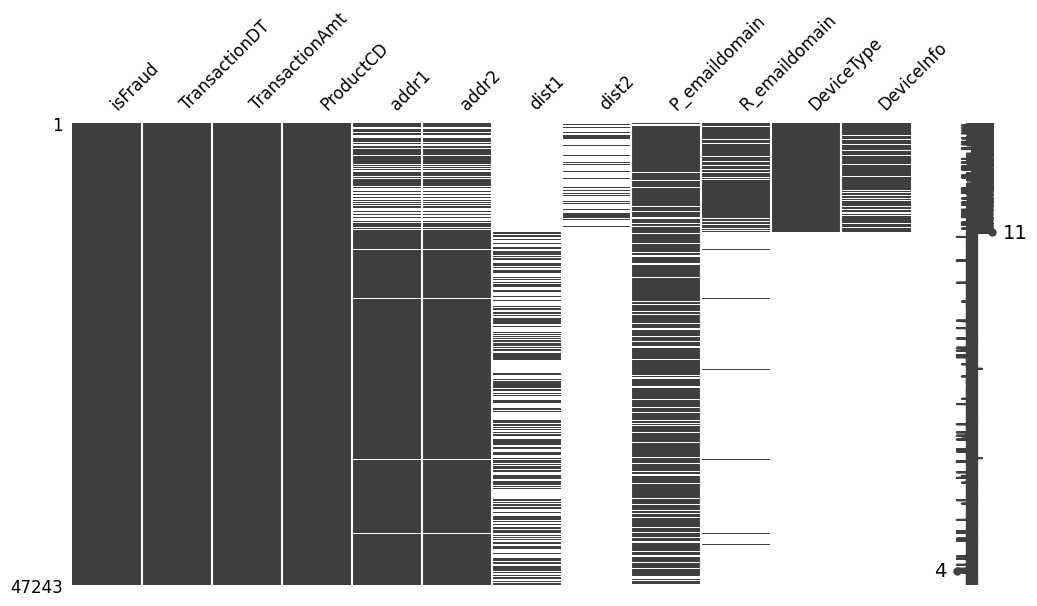

In [33]:
sorte_DeviceType = df_train.sort_values('DeviceType')
msno.matrix(sorte_DeviceType)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(12, 6)

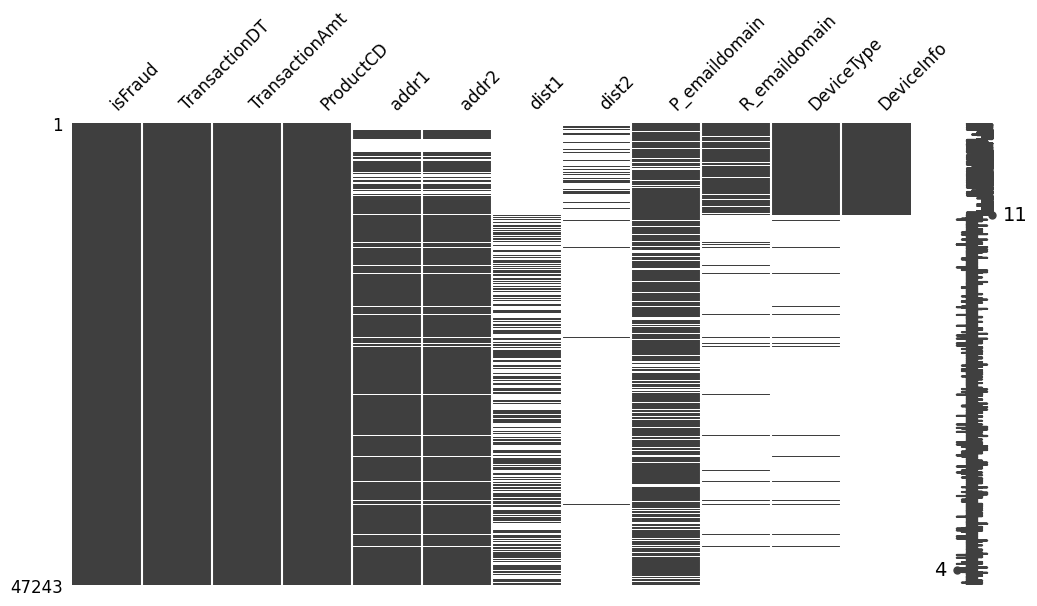

In [34]:
sorte_DeviceType = df_train.sort_values('DeviceInfo')
msno.matrix(sorte_DeviceType)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(12, 6)

### 5.2.3 Correlación de valores perdidos entre columnas

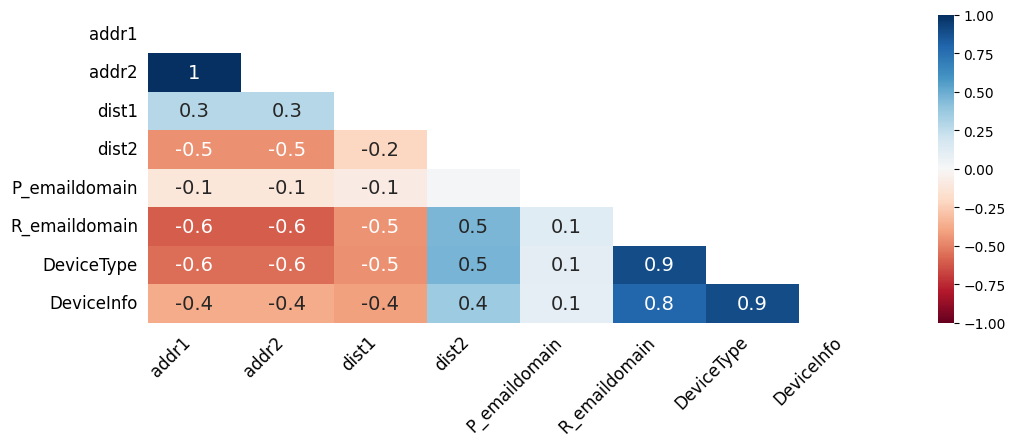

In [35]:

msno.heatmap(df_train)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(12, 4)

Se puede observar que de la gráfica de correlación de valores nulos hay varias características estan correlacionadas, vamos a estudiar el porque de esats correlaciones

In [36]:
df_train.groupby(['addr1', 'addr2']).size().sort_values(ascending=False)

addr1  addr2
299.0  87.0     3679
325.0  87.0     3402
204.0  87.0     3325
264.0  87.0     3093
330.0  87.0     2079
                ... 
321.0  87.0        1
353.0  87.0        1
373.0  87.0        1
385.0  96.0        1
296.0  98.0        1
Length: 139, dtype: int64

#### addr2 y add1

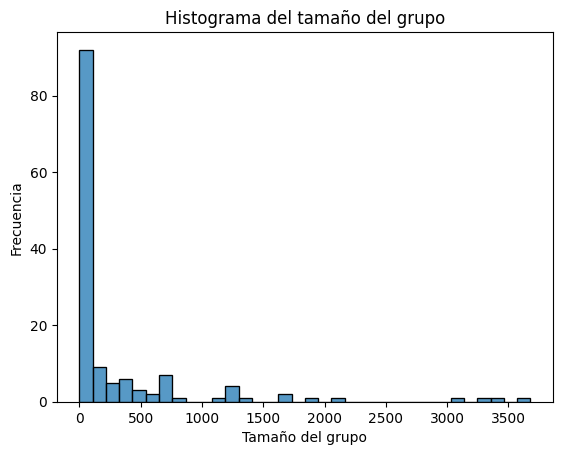

In [37]:
## addr2 y add1
sns.histplot(df_train.groupby(['addr1', 'addr2']).size())
plt.title('Histograma del tamaño del grupo')
plt.xlabel('Tamaño del grupo')
plt.ylabel('Frecuencia')
plt.show()

In [38]:
df_train.groupby(['addr1', 'addr2']).size().sort_values(ascending=False).nunique()

69

Se identificaron un total de 65 tipos de conexiones entre las variables 'addr1' y 'addr2'. Ambas variables muestran un porcentaje de valores perdidos del 11.13% en sus registros, y se observa una coincidencia completa en aquellos registros donde falta información en la columna 'addr1' también carecen de datos en la columna 'addr2'. Se sugiere abordar la imputación de valores faltantes mediante el reemplazo con los valores más frecuentes de cada respectiva columna para preservar la integridad y completitud de los datos

#### dist2 y dist1

dist2 y dist1 tienen una correlación muy baja, y dist1 tiene casi un 60% de valores perdidos y dist2 tienen casi un 94% perdidos, se recomienda eliminar las columnas

#### P_emaildomain y R_emaildomain


Las variables muestran una correlación baja entre sí, y la columna 'R_emaildomain' presenta un alto porcentaje de valores perdidos. Por lo tanto, se sugiere eliminar dicha columna para simplificar el conjunto de datos. En cuanto a 'P_emaildomain', dado que representa direcciones de correo electrónico, se propone imputar los valores faltantes utilizando el método de reemplazo con el valor más frecuente, lo que contribuirá a preservar la integridad de los datos en esa columna específica


### DeviceType  y DeviceInfo
Las columnas 'DeviceType' y 'DeviceInfo' presentan una elevada tasa de valores perdidos, con porcentajes del 76.17% y 80.08%, respectivamente. Dada la extensión de la ausencia de datos en ambas columnas, se recomienda proceder con la eliminación de estas para mantener la calidad y consistencia del conjunto de datos.

### **5.3 Valores Duplicados**

In [39]:
df_train[df_train.duplicated(keep=False)].count()

isFraud           0
TransactionDT     0
TransactionAmt    0
ProductCD         0
addr1             0
addr2             0
dist1             0
dist2             0
P_emaildomain     0
R_emaildomain     0
DeviceType        0
DeviceInfo        0
dtype: int64

#### Observación: no hay datos duplicados

## **6.Análisis de univariante**

### **6.1 Columna fraude ('isFraud')**

Comenzamos el análisis focalizándonos en la columna "isFraud", ya que representa el resultado de nuestros predictores o características. Evaluamos la cantidad de registros y representaremos visualmente esta información mediante un gráfico de barras, con el propósito de ilustrar la cantidad de registros clasificados como fraude y aquellos que no lo son.

<ipython-input-40-24426d109b95>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fraude, x='isFraud', y='count', palette=['tab:blue', 'tab:red'], ax=ax)


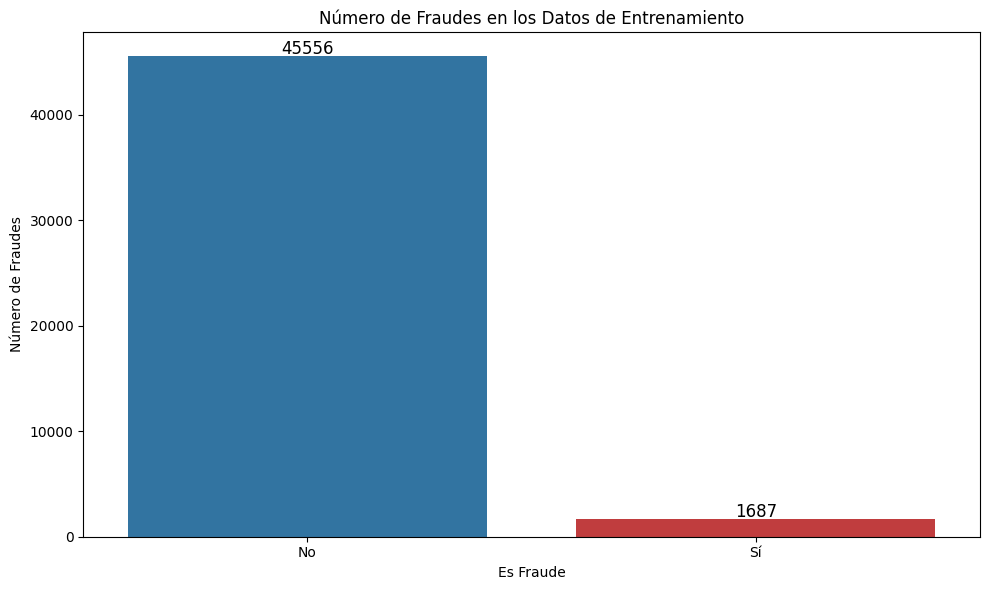

In [40]:
# Calcular los números de fraudes en los datos de entrenamiento
Numero_fraude = df_train.isFraud.value_counts()
df_fraude = pd.DataFrame(Numero_fraude).rename(index={0: 'No', 1: 'Sí'})
df_fraude.reset_index(inplace=True)
df_fraude.columns = ['isFraud', 'count']  # Renombrar columnas para usar en seaborn

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(10, 6))

# Crear el gráfico de barras
sns.barplot(data=df_fraude, x='isFraud', y='count', palette=['tab:blue', 'tab:red'], ax=ax)

# Etiquetas y título
ax.set_ylabel('Número de Fraudes')
ax.set_title('Número de Fraudes en los Datos de Entrenamiento')
ax.set_xlabel('Es Fraude')

# Añadir etiquetas a las barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

# Añadir el texto de la figura
#fig.text(0.5, -0.1, "fig. transacciones con fraude y sin fraude de los datos de entrenamiento fraccionados",
  #       ha='center', va='top', fontsize=10)

# Ajustar el diseño para que no se recorten elementos
plt.tight_layout()

# Guardar la figura
plt.savefig(base_dir + 'balance_datos.png')

# Mostrar la figura
plt.show()


In [41]:
import pandas as pd

# Calcular los porcentajes de fraudes en los datos de entrenamiento
porcentaje_fraude = df_train['isFraud'].value_counts(normalize=True) * 100

# Crear un DataFrame con los porcentajes
df_porcentaje_fraude = pd.DataFrame(porcentaje_fraude)

# Renombrar las columnas
df_porcentaje_fraude.columns = ['Porcentaje']

# Restaurar los índices originales
df_porcentaje_fraude.reset_index(inplace=True)

# Renombrar las categorías
df_porcentaje_fraude['isFraud'] = df_porcentaje_fraude['isFraud'].map({0: 'No', 1: 'Sí'})

# Mostrar el DataFrame
df_porcentaje_fraude


isFraud  Porcentaje
0      No   96.429101
1      Sí    3.570899

Obervación:
**Cantidad de registros por archivo**

| Es Fraude | N° de Registros |
| ------------ | ------------ |
| No| 96,45%|
| Sí| 3.54%|

Se destaca que la mayoría abrumadora de las transacciones se encuentran en la categoría no fraudulenta, mientras que solo una fracción mínima corresponde a casos de fraude. Este desbalance en los datos puede representar un desafío significativo para el proceso de aprendizaje automático, ya que los modelos pueden tener dificultades para identificar y aprender patrones en las clases minoritarias debido a su escasez relativa

### **6.2 columna Importe del pago por transacción en USD (TransactionAmt)**


Analizamos la asociación entre la columna "TransactionAmt", que representa los importes de cada transacción, y la columna de fraude. Este análisis incluye la evaluación de la distribución de los montos en relación con la presencia de fraudes.







In [42]:
df_train[['TransactionAmt']].describe().round(2)

TransactionAmt
count        47243.00
mean           136.47
std            276.13
min              0.35
25%             43.97
50%             68.95
75%            125.00
max          31937.39

In [43]:
limite_amt = calculo_quantile(df_train,'TransactionAmt')

Primer Cuartil (Q1): 43.97
Tercer Cuartil (Q3): 125.0
Rango Intercuartil (IQR): 81.03
Límite Inferior: -77.575
Límite Superior: 246.54500000000002


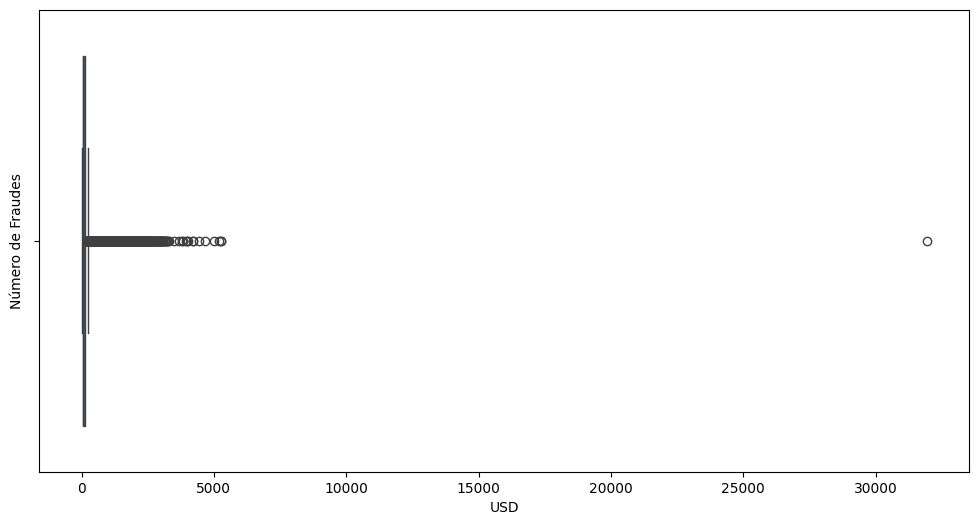

In [44]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_train, x='TransactionAmt')
plt.ylabel('Número de Fraudes')
plt.xlabel('USD')
plt.savefig(base_dir + 'trabs_total_box_plot')
plt.show()

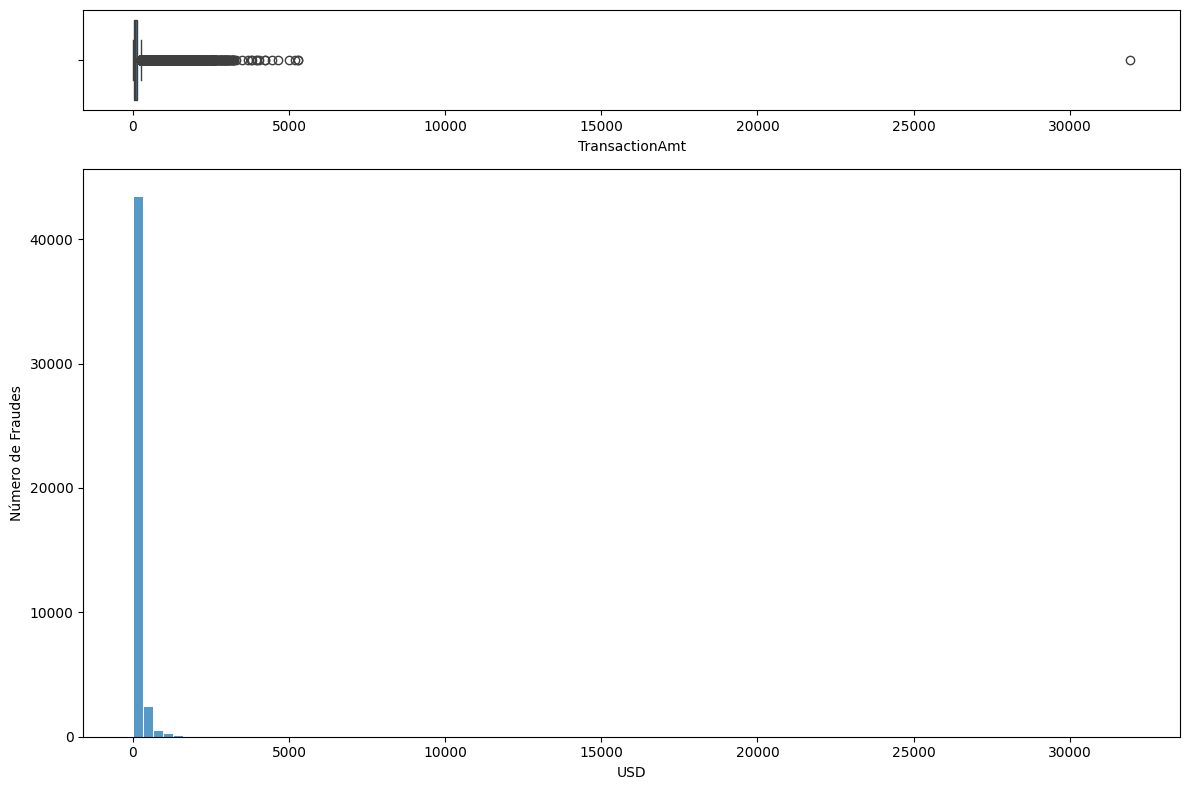

In [45]:
fig, axs = plt.subplots(2, 1, tight_layout=True, figsize=(12, 8), gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(data=df_train, x='TransactionAmt', ax=axs[0])
sns.histplot(data=df_train, x='TransactionAmt', bins=100
             , color='tab:blue', edgecolor="white", linewidth=0.7, label='No',  ax=axs[1])
axs[1].set_ylabel('Número de Fraudes')
axs[1].set_xlabel('USD')
plt.savefig(base_dir + 'trabs_total')
plt.show()


|index|TransactionAmt|
|---|---|
|count|59054|
|mean|135\.23|
|std|265\.42|
|min|0\.35|
|25%(Q1)|43\.29|
|50%|68\.5|
|75%(Q3)|125\.0|
|max|31937\.39|
|IQR|81.70|
|Límite Inferior|-79.27|
|Límite Superior|247.5|

Observación:

En la representación gráfica de la distribución y en la tabla de estadísticos asociada a la columna "TransactionAmt", se destacan las siguientes observaciones:

Se evidencia una notable disparidad del 50% entre la mediana y la media de los valores.

La comparación entre el límite superior del rango intercuartil y el valor máximo revela discrepancias significativas en órdenes de magnitud, indicando la presencia de datos atípicos.

### **6.3 columna Intervalo de tiempo (**TransactionDT**)**

In [46]:
df_train[['TransactionDT']].describe().round(2)

TransactionDT
count       47243.00
mean      7352619.09
std       4597070.22
min         86469.00
25%       3064451.00
50%       7271057.00
75%      11133229.50
max      15810563.00

In [47]:
limite_M1 = calculo_quantile(df_train,'TransactionDT')

Primer Cuartil (Q1): 3064451.0
Tercer Cuartil (Q3): 11133229.5
Rango Intercuartil (IQR): 8068778.5
Límite Inferior: -9038716.75
Límite Superior: 23236397.25


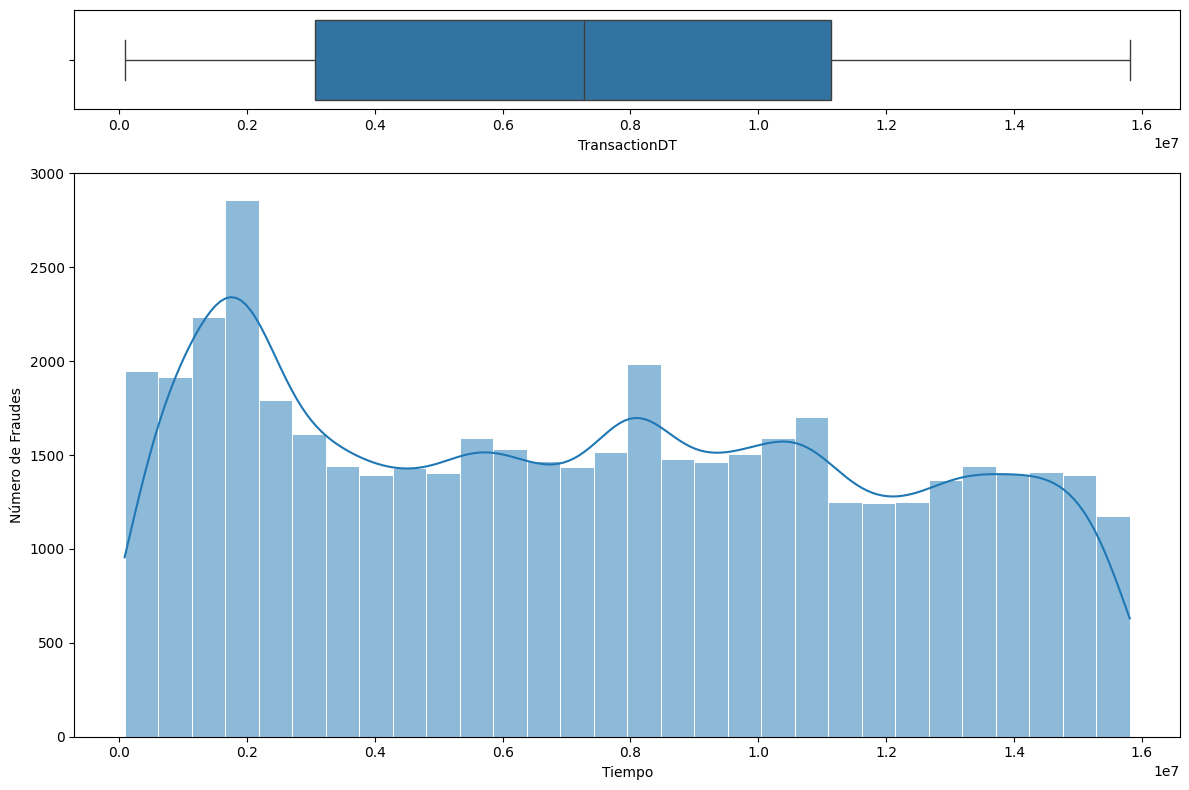

In [48]:
fig, axs = plt.subplots(2, 1, tight_layout=True, figsize=(12, 8), gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(data=df_train, x='TransactionDT', ax=axs[0])
sns.histplot(data=df_train, x='TransactionDT', bins=30
             , color='tab:blue', edgecolor="white", linewidth=0.7, label='No',  ax=axs[1],kde=True)
axs[1].set_ylabel('Número de Fraudes')
axs[1].set_xlabel('Tiempo')
plt.tight_layout()

plt.savefig(base_dir + 'tiempo_total')


plt.show()

**Observación:** La distribución de los tiempo de transacción es casi uniforme, aunuque se observa que algunos tiempo de transacciones son más frecuente que otros.

### **6.4 Columna ProductCD**

In [49]:
df_train['ProductCD'].unique()

array(['W', 'H', 'C', 'R', 'S'], dtype=object)

<ipython-input-50-c119286808fd>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(productCD,ax=ax,palette="tab10")


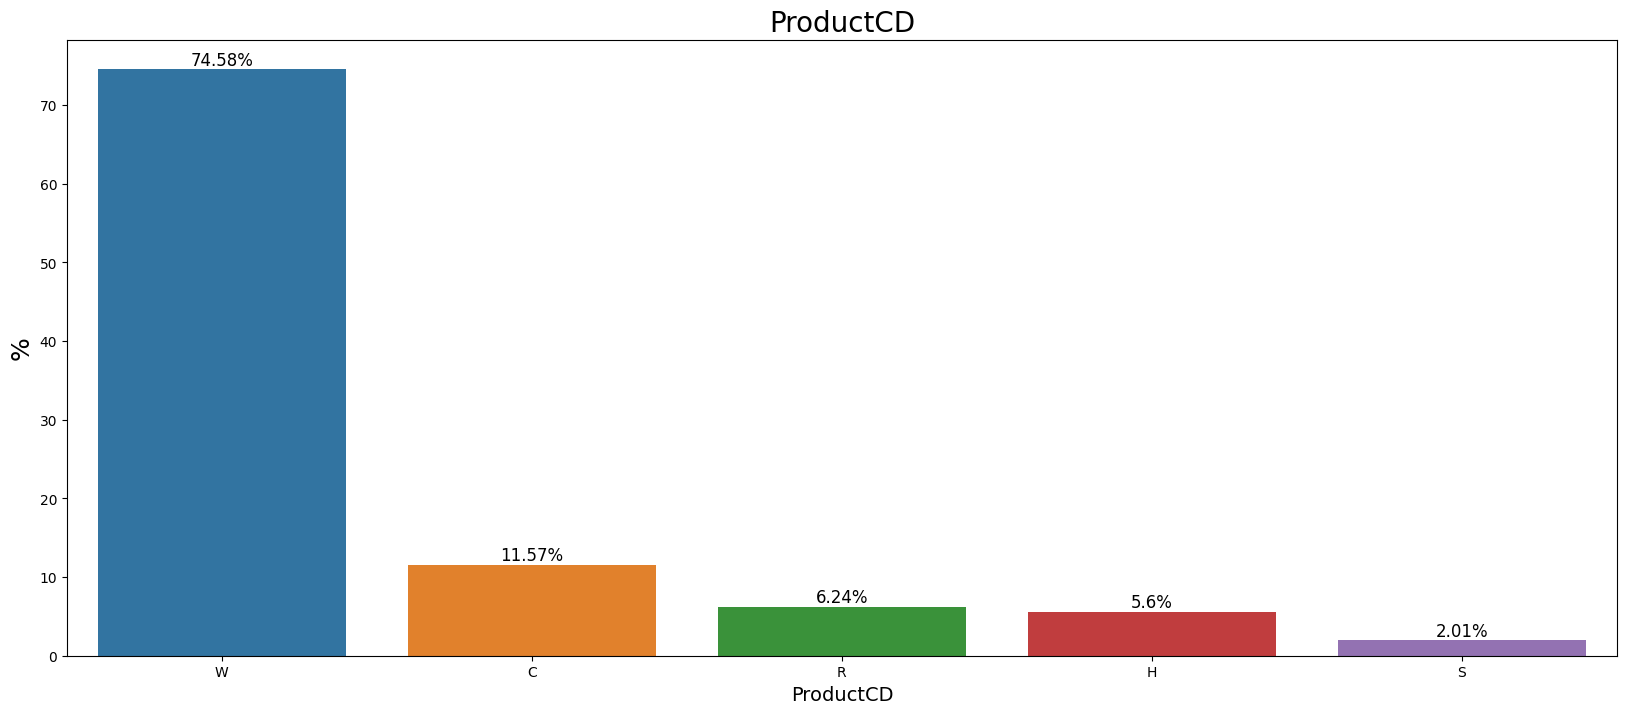

In [50]:
productCD = round((df_train['ProductCD'].value_counts()/len(df_train['ProductCD']))*100,2)
fig, ax = plt.subplots(figsize=(20, 8))
sns.barplot(productCD,ax=ax,palette="tab10")
plt.title('ProductCD', fontsize=20)
plt.xlabel('ProductCD', fontsize=14)
plt.ylabel('%', fontsize=18)
for container in ax.containers:
    ax.bar_label(container, fmt='%g%%', color='black', fontsize=12)
plt.savefig(base_dir+'productcd')
plt.show()

**Observación:** El tipo de producto con mayor transacción es el "W" con 74.39%, seguido del producto "C" con 11.55%

### **6.5 Columna Address** **texto en negrita**

**addr1**

In [51]:
df_train['addr1'].nunique()

122

In [52]:
df_train['addr1'].isnull().sum()

5223

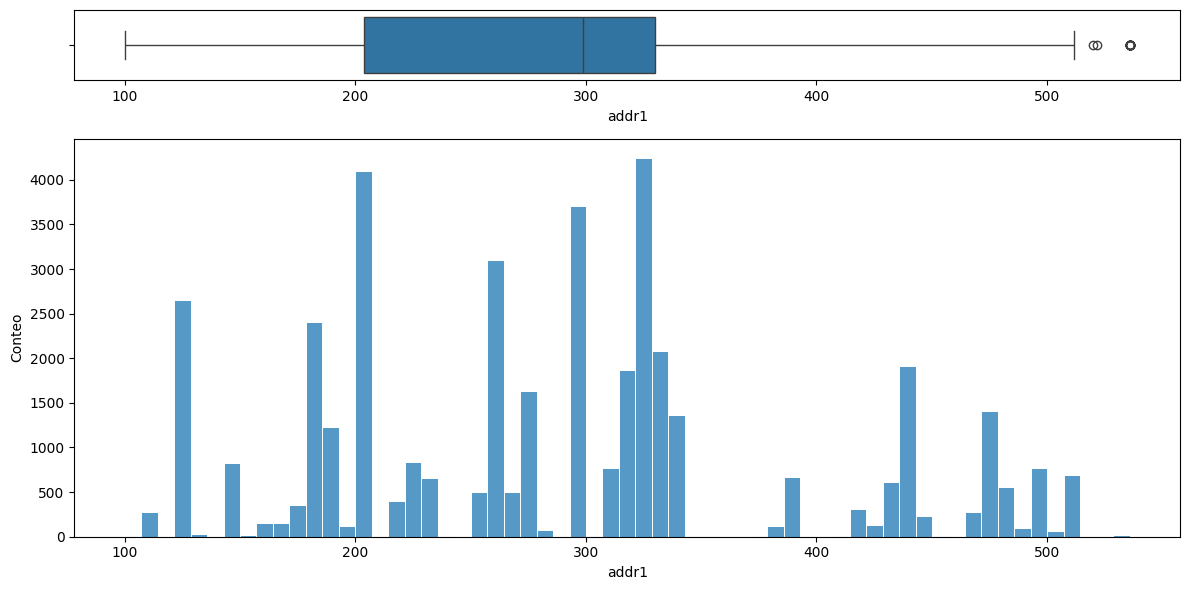

In [53]:
fig, axs = plt.subplots(2, 1, tight_layout=True, figsize=(12, 6), gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(data=df_train, x='addr1', ax=axs[0])
sns.histplot(data=df_train, x='addr1'
             , color='tab:blue', edgecolor="white", linewidth=0.7, label='No',  ax=axs[1])
axs[1].set_ylabel('Conteo')
axs[1].set_xlabel('addr1')
plt.show()

**addr2**

In [54]:
df_train['addr2'].nunique()

27

In [55]:
df_train['addr2'].isnull().sum()

5223

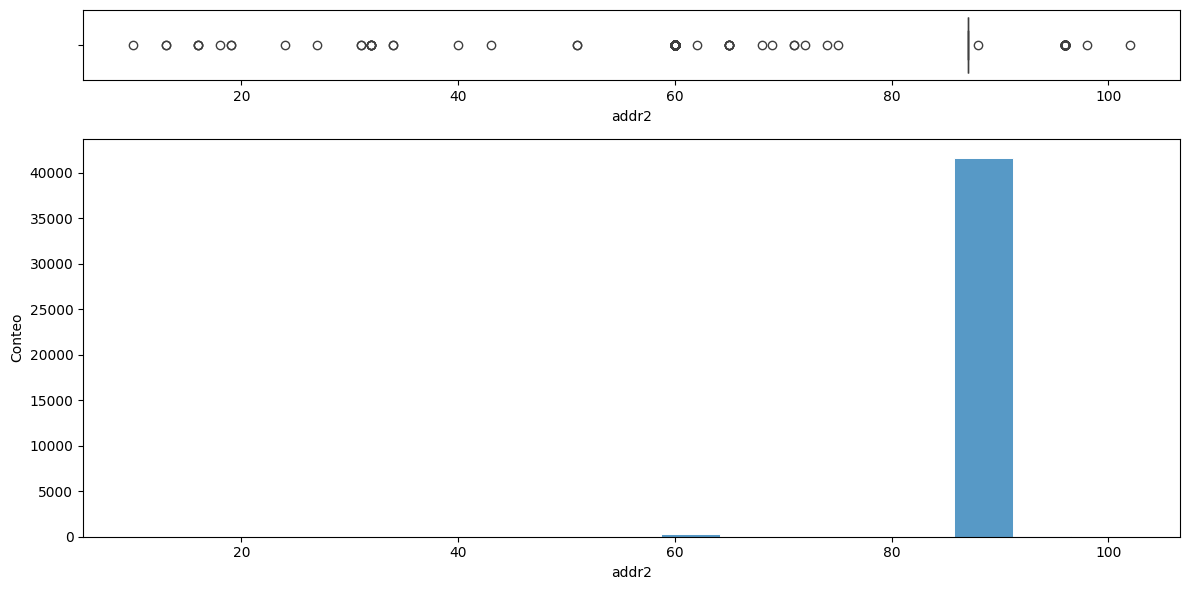

In [56]:
fig, axs = plt.subplots(2, 1, tight_layout=True, figsize=(12, 6), gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(data=df_train, x='addr2', ax=axs[0])
sns.histplot(data=df_train, x='addr2'
             , color='tab:blue', edgecolor="white", linewidth=0.7, label='No',  ax=axs[1])
axs[1].set_ylabel('Conteo')
axs[1].set_xlabel('addr2')
plt.show()

In [57]:
addr = df_train.groupby(['addr1','addr2']).size()
addr_resultado = addr.reset_index(name='N° Ruta')
addr_resultado = addr_resultado.sort_values(by='N° Ruta', ascending=False)
addr_resultado.head(10)


addr1  addr2  N° Ruta
72   299.0   87.0     3679
82   325.0   87.0     3402
32   204.0   87.0     3325
50   264.0   87.0     3093
84   330.0   87.0     2079
79   315.0   87.0     1864
111  441.0   87.0     1663
52   272.0   87.0     1636
7    123.0   87.0     1323
25   184.0   87.0     1246

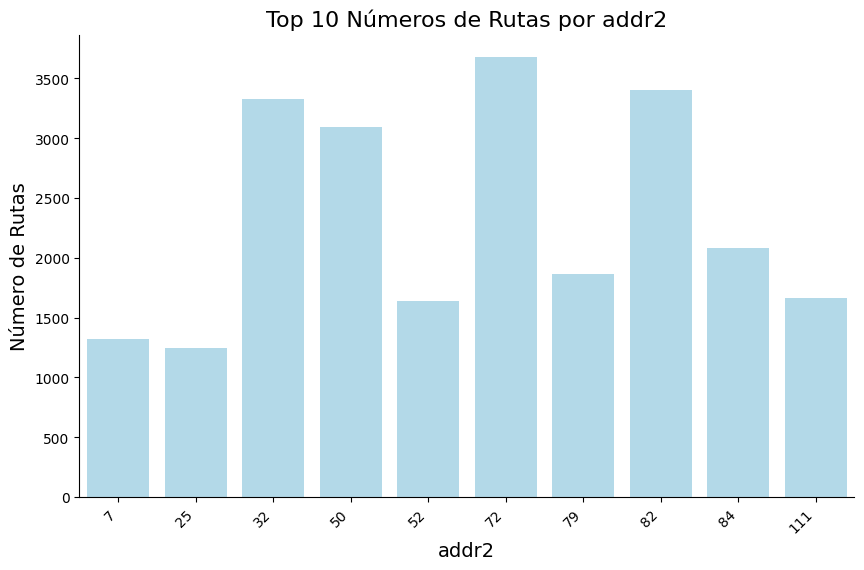

In [58]:
top_10 = addr_resultado.nlargest(10, 'N° Ruta')
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10.index, y='N° Ruta', data=top_10, color='skyblue', alpha=0.7)
plt.title('Top 10 Números de Rutas por addr2', fontsize=16)
plt.xlabel('addr2', fontsize=14)
plt.ylabel('Número de Rutas', fontsize=14)
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.show()


**Observación:**
- addr1: Tiene 129 direcciones diferentes
- addr2: Tiene 29 direcciones diferentes
En la tabla se muestra las 10 ruta con mayor número de transacciones

|index|addr1|addr2|N° Ruta|
|---|---|---|---|
|69|299\.0|87\.0|3705|
|80|325\.0|87\.0|3413|
|31|204\.0|87\.0|3276|
|49|264\.0|87\.0|3098|
|82|330\.0|87\.0|2128|
|76|315\.0|87\.0|1888|
|112|441\.0|87\.0|1654|
|51|272\.0|87\.0|1642|
|7|123\.0|87\.0|1299|
|25|191\.0|87\.0|1245|

**Nos servira para hacer una nueva varible N°Ruta **

### **6.6 Columna dist** **texto en negrita**

In [59]:
df_train[['dist1','dist2']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 47243 entries, 542017 to 166626
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   dist1   19019 non-null  float64
 1   dist2   2953 non-null   float64
dtypes: float64(2)
memory usage: 1.1 MB


In [60]:
df_train[['dist1','dist2']].describe()

dist1         dist2
count  19019.000000   2953.000000
mean     113.508544    245.387741
std      354.763147    570.107206
min        0.000000      0.000000
25%        3.000000      7.000000
50%        8.000000     40.000000
75%       24.000000    226.000000
max     6466.000000  11623.000000

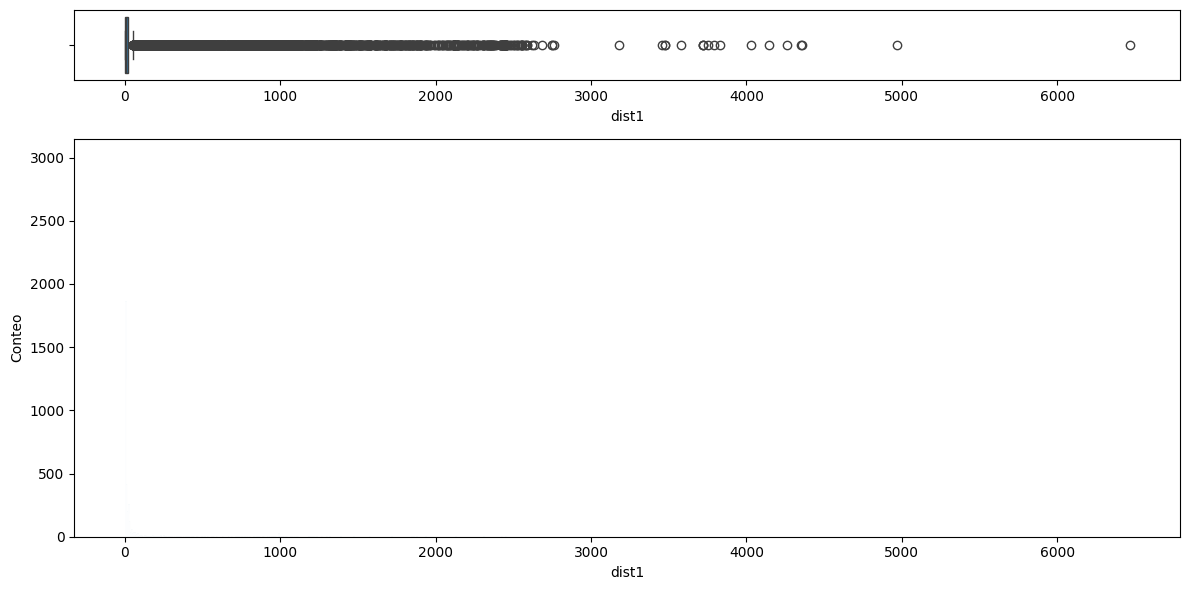

In [61]:
fig, axs = plt.subplots(2, 1, tight_layout=True, figsize=(12, 6), gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(data=df_train, x='dist1', ax=axs[0])
sns.histplot(data=df_train, x='dist1'
             , color='tab:blue', edgecolor="white", linewidth=0.7, label='No',  ax=axs[1])
axs[1].set_ylabel('Conteo')
axs[1].set_xlabel('dist1')
plt.show()

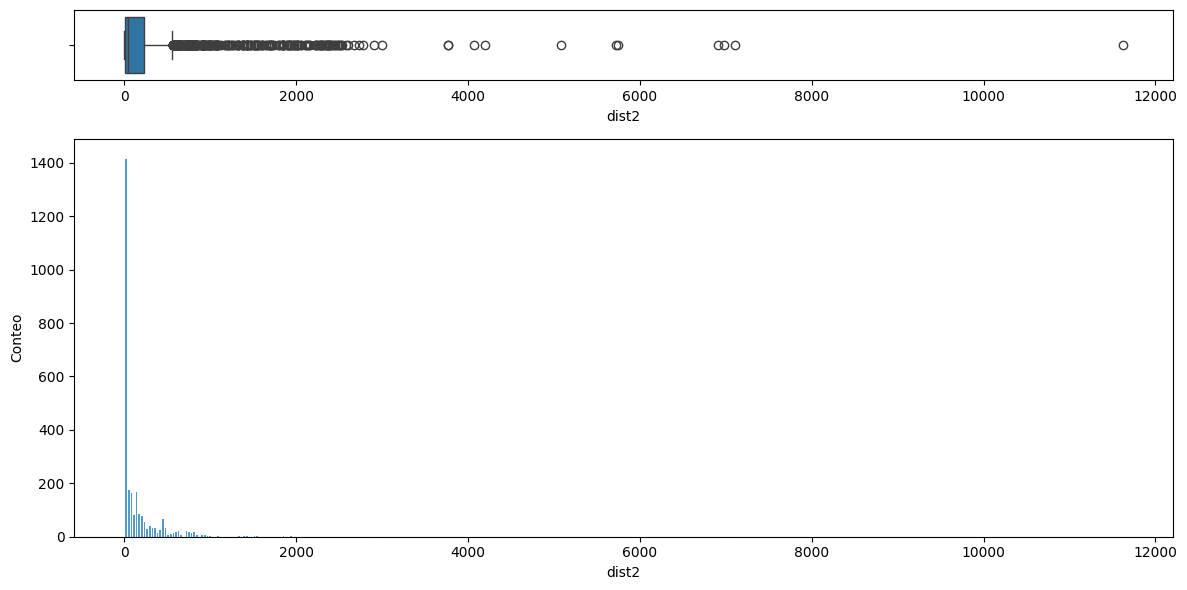

In [62]:
fig, axs = plt.subplots(2, 1, tight_layout=True, figsize=(12, 6), gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(data=df_train, x='dist2', ax=axs[0])
sns.histplot(data=df_train, x='dist2'
             , color='tab:blue', edgecolor="white", linewidth=0.7, label='No',  ax=axs[1])
axs[1].set_ylabel('Conteo')
axs[1].set_xlabel('dist2')
plt.show()

In [63]:
dist = df_train.groupby(['dist1','dist2']).size()
dist


Series([], dtype: int64)

**Observación:**No tenemos filas donde coincidan a la vez la dist1 con dist2, es decir cuando uno de las columna de distancia tiene un valor la otra no la tiene.

### **6.7 Columna P_emaildomain y R_emaildomain**

In [64]:
df_train['P_emaildomain'].value_counts().head(10)

P_emaildomain
gmail.com        18154
yahoo.com         8181
hotmail.com       3623
anonymous.com     2922
aol.com           2291
comcast.net        608
icloud.com         524
outlook.com        435
msn.com            319
att.net            304
Name: count, dtype: int64

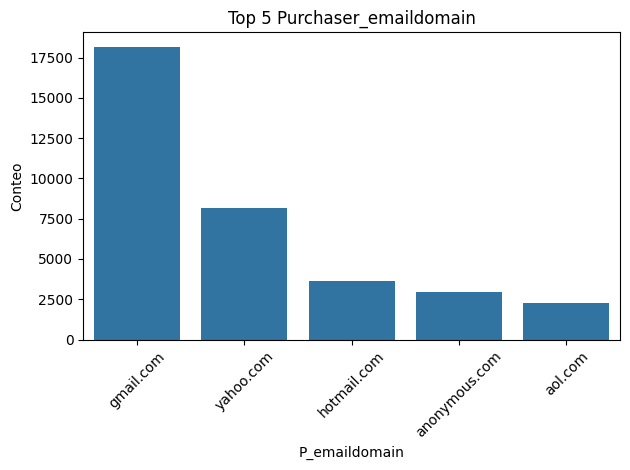

In [65]:
top_5_values = df_train['P_emaildomain'].value_counts().head(5)
sns.countplot(data=df_train, x='P_emaildomain', order=top_5_values.index)
plt.xticks(rotation=45)
plt.title('Top 5 Purchaser_emaildomain')
plt.xlabel('P_emaildomain')
plt.ylabel('Conteo')
plt.tight_layout()
plt.savefig(base_dir+ 'emaildomaintop5')

plt.show()


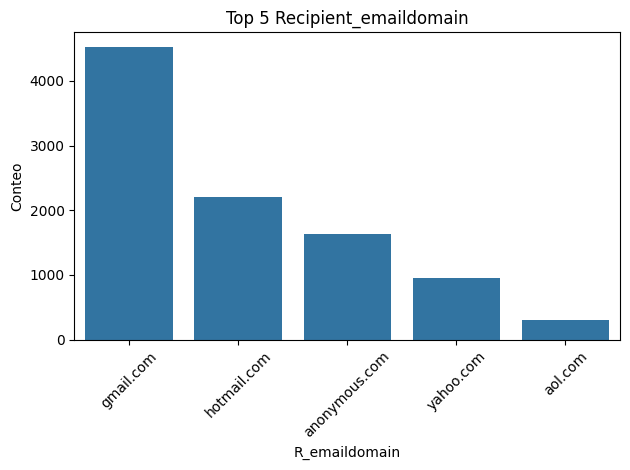

In [66]:
top_5_values = df_train['R_emaildomain'].value_counts().head(5)
sns.countplot(data=df_train, x='R_emaildomain', order=top_5_values.index)
plt.xticks(rotation=45)
plt.title('Top 5 Recipient_emaildomain')
plt.xlabel('R_emaildomain')
plt.ylabel('Conteo')
plt.tight_layout()
plt.savefig(base_dir+ 'emailRdomaintop5')
plt.show()


**Observación:** Dominio de correo electrónico del comprador (purchaser) y del destinatario (recipient) respectivamente la mayor parte de la transacción lo hace con "gmail"

### **6.7 Columna DeviceType** **texto en negrita**

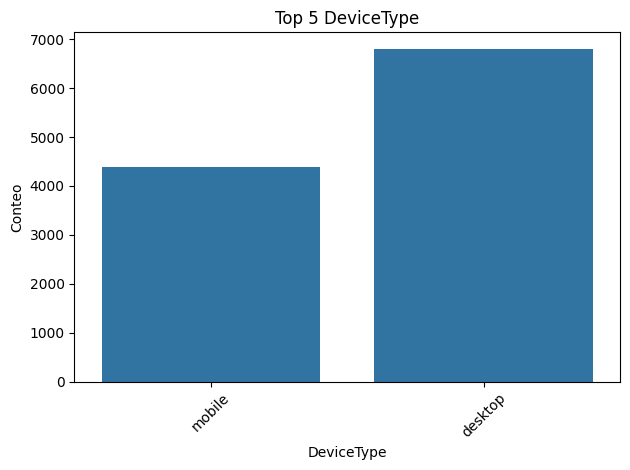

In [67]:

sns.countplot(data=df_train, x='DeviceType')
plt.xticks(rotation=45)
plt.title('Top 5 DeviceType')
plt.xlabel('DeviceType')
plt.ylabel('Conteo')
plt.tight_layout()
plt.savefig(base_dir+ 'devicetop5')
plt.show()


### **6.7 Columna Deviceinfo**

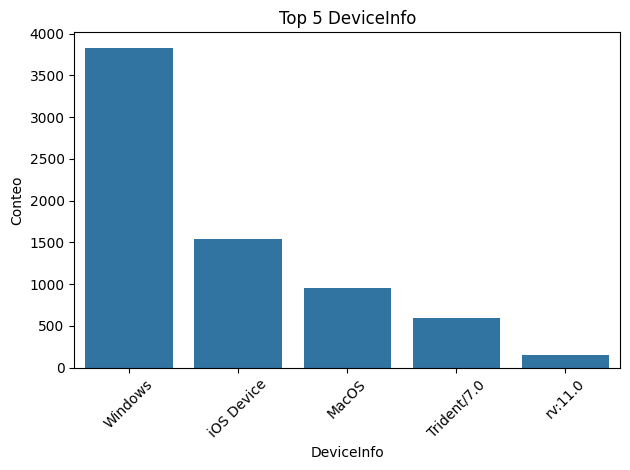

In [68]:
top_5_values = df_train['DeviceInfo'].value_counts().head(5)
sns.countplot(data=df_train, x='DeviceInfo', order=top_5_values.index)
plt.xticks(rotation=45)
plt.title('Top 5 DeviceInfo')
plt.xlabel('DeviceInfo')
plt.ylabel('Conteo')
plt.tight_layout()
plt.savefig(base_dir+ 'deviceinfop5')

plt.show()



## **7 Análisis Bivariante**

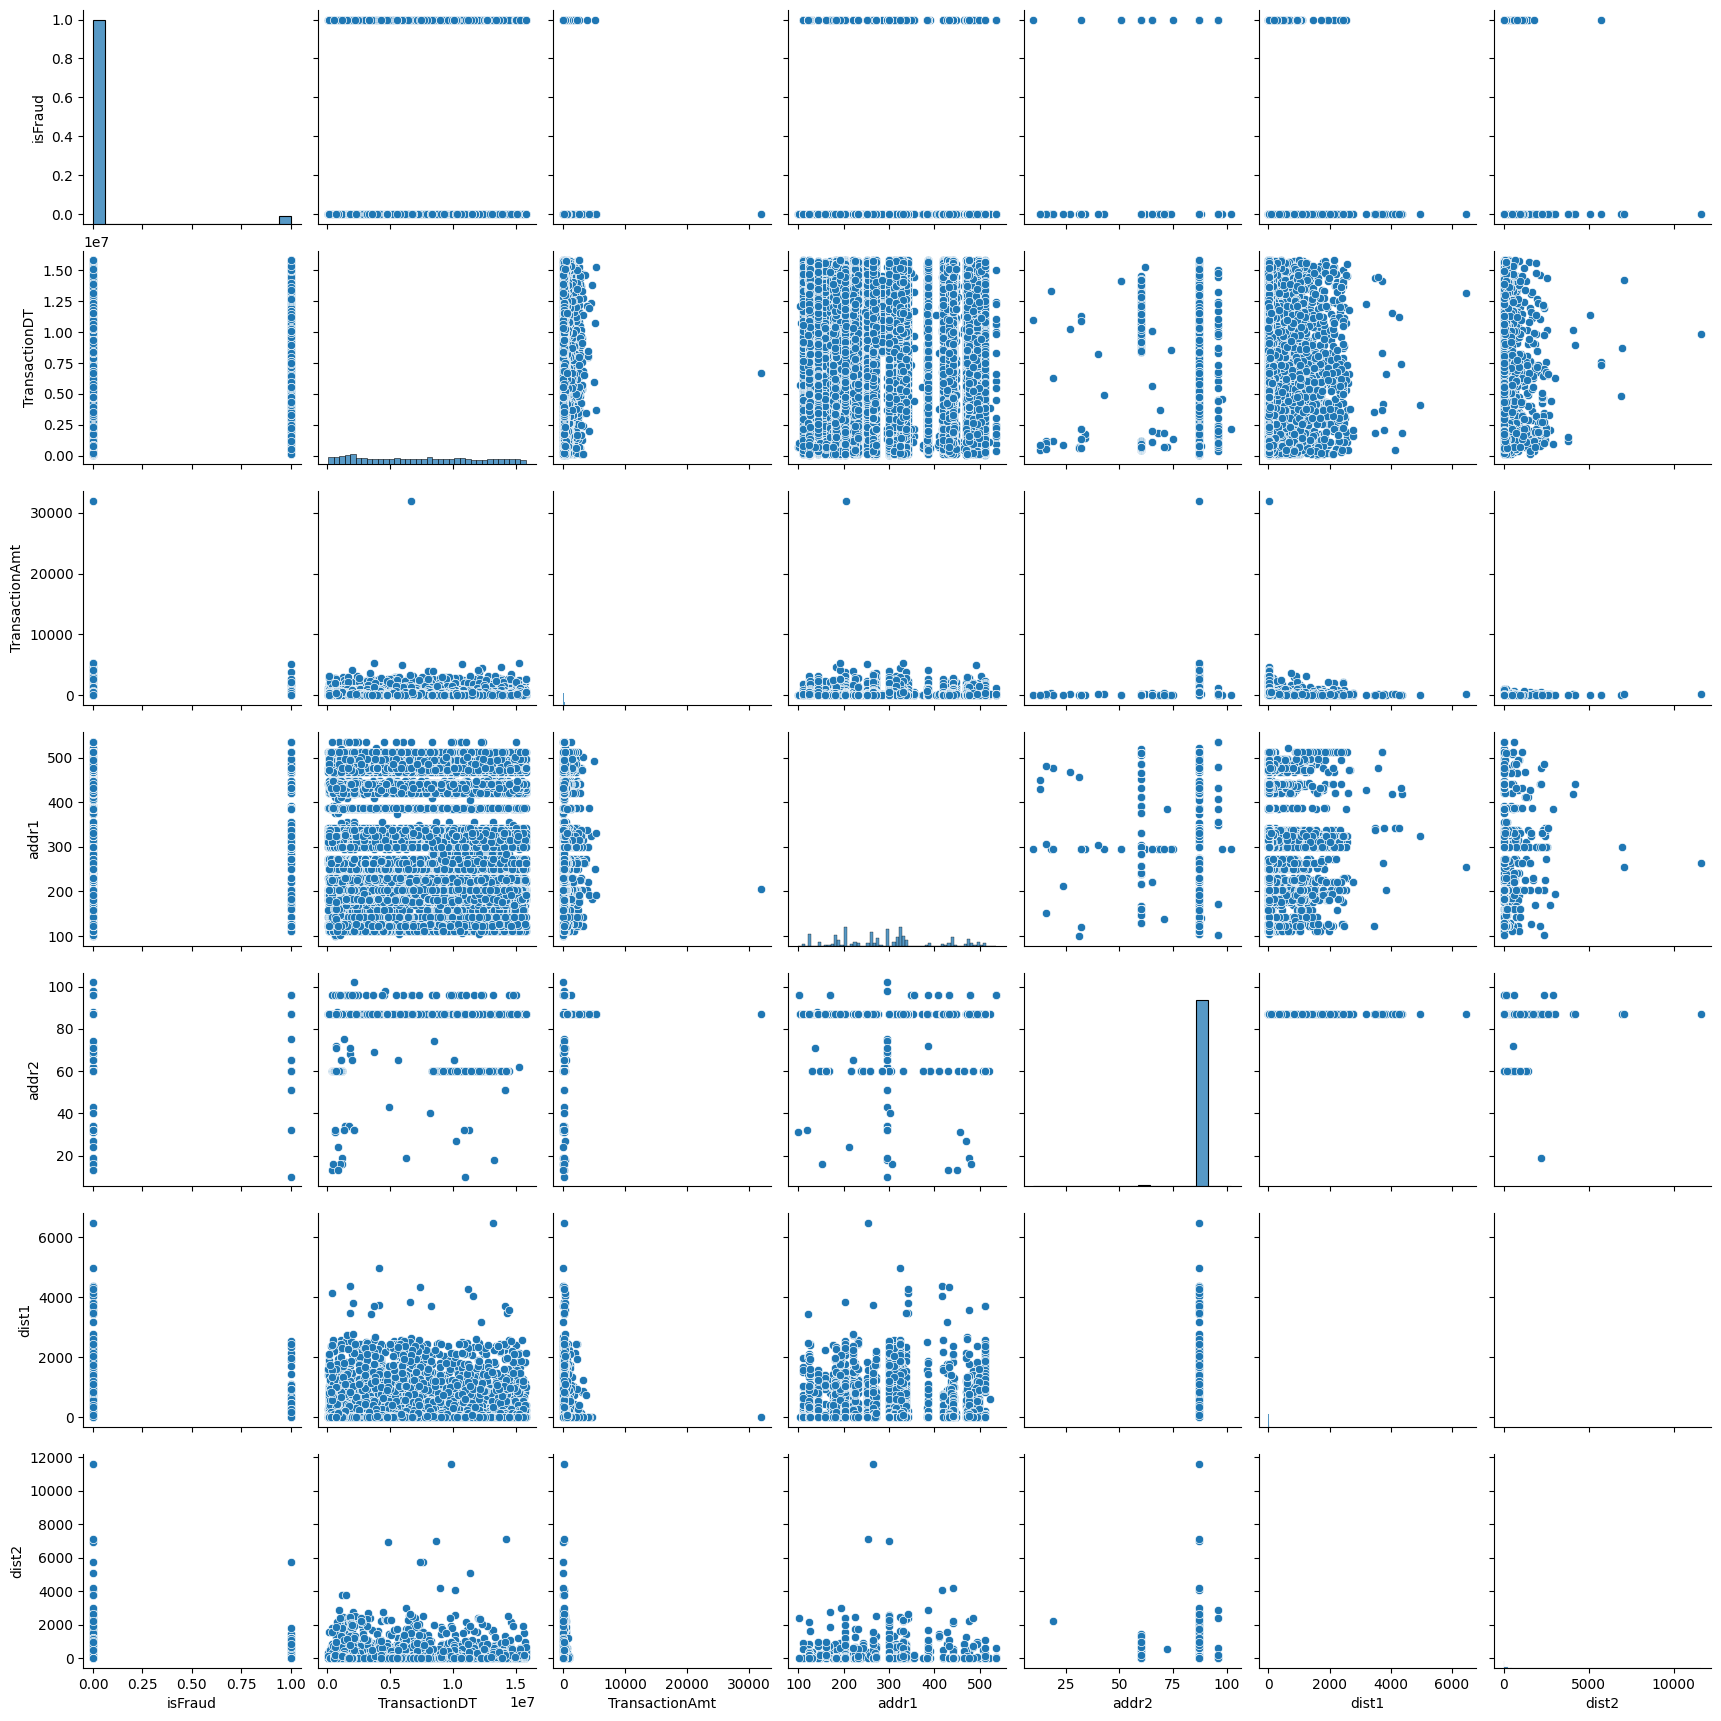

In [69]:
sns.pairplot(data=df_train)

### **7.2 Análisis de la columna "TransactionAmt" segmentado por fraudes y no fraudes**

En esta sección, realizaremos un análisis específico de la columna "TransactionAmt", considerando la segmentación entre transacciones fraudulentas y no fraudulentas. Este enfoque nos permitirá examinar de manera detallada la distribución de los montos de transacciones en cada categoría, proporcionando insights valiosos sobre posibles patrones o tendencias asociadas con el fraude.

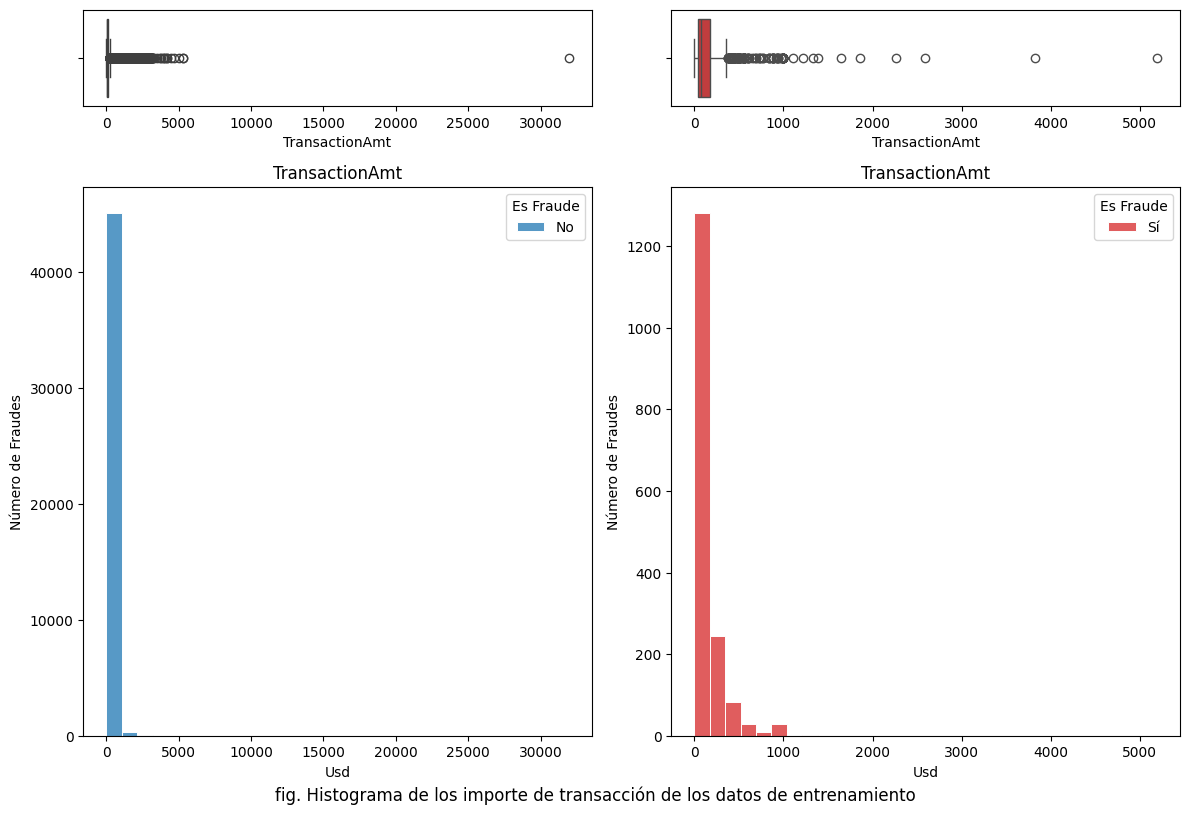

In [70]:
grafica_histo_boxplot(df_train,'TransactionAmt','Usd',"fig. Histograma de los importe de transacción de los datos de entrenamiento",kde=False)
plt.tight_layout()
plt.savefig(base_dir + 'trans_segmentado_total')

plt.show()

In [71]:
df_importe = df_train[['isFraud','TransactionAmt']]
df_importe[df_importe['isFraud'] == 0].describe()

isFraud  TransactionAmt
count  45556.0    45556.000000
mean       0.0      135.929813
std        0.0      276.845554
min        0.0        0.755000
25%        0.0       44.000000
50%        0.0       68.950000
75%        0.0      125.000000
max        0.0    31937.391000

In [72]:
df_importe[df_importe['isFraud'] == 1].describe()

isFraud  TransactionAmt
count   1687.0     1687.000000
mean       1.0      151.167841
std        0.0      255.548549
min        1.0        0.350000
25%        1.0       38.065000
50%        1.0       76.950000
75%        1.0      171.000000
max        1.0     5191.000000

In [73]:
df_train[['TransactionAmt']].describe()

TransactionAmt
count    47243.000000
mean       136.473947
std        276.125302
min          0.350000
25%         43.970000
50%         68.950000
75%        125.000000
max      31937.391000

**Observación:**


|   | Fraude (Sí) | No Fraude | Total |
| ------------ | ------------ | ------------ |  ------------ |
| Media    | 152.49|135.81 |136.39|
| Mediana | 77.00| 68.02|68.50|
| Máximo   | 5191.00| 31937.39|31937.39|
| Mínimo     |0.29| 0.88|0.29|
| 75%  |170.00| 120.00|125.00|


Con la segmentación de fraude, se identificaron varias observaciones notables en las distribuciones de las transacciones con y sin fraude:

- Ambas distribuciones con y sin fraude muestran un sesgo hacia la izquierda, indicando una concentración de transacciones en los valores más bajos.

- El rango de los importes de las transacciones es muy amplio, abarcando desde 0.292 hasta 31937.391 dólares. Este amplio rango sugiere una variabilidad significativa en los datos.

- La diferencia entre el valor medio y la mediana es considerable, señalando una asimetría en la distribución.

- Se observaron valores atípicos (outliers) en ambas distribuciones, indicando transacciones inusuales o extremadamente altas.

Dada la naturaleza del rango extenso, el sesgo y la presencia de outliers, se propone segmentar el DataFrame en diferentes rangos de importe por lo que se propone dos forma cuales son las siguientes:
- 1.Separando los valores atípicos usando rango intercuartil
- 2.Separar con alguno criterio de segmentación de mercado.

Estas estrategias buscan mejorar la comprensión de los datos al agrupar las transacciones en categorías más manejables y reveladoras.

**Elegiremos la opción número 1 y evaluaremos los resultados**






### **7.2.1 Separación de los Valores Atípicos Utilizando el Rango Intercuartil**

En esta sección, implementaremos la estrategia de segmentación que consiste en separar los valores atípicos mediante el rango intercuartil. Esta técnica nos permitirá aislar transacciones que se desvían significativamente de la tendencia central, ofreciendo una visión más detallada y precisa de los datos.

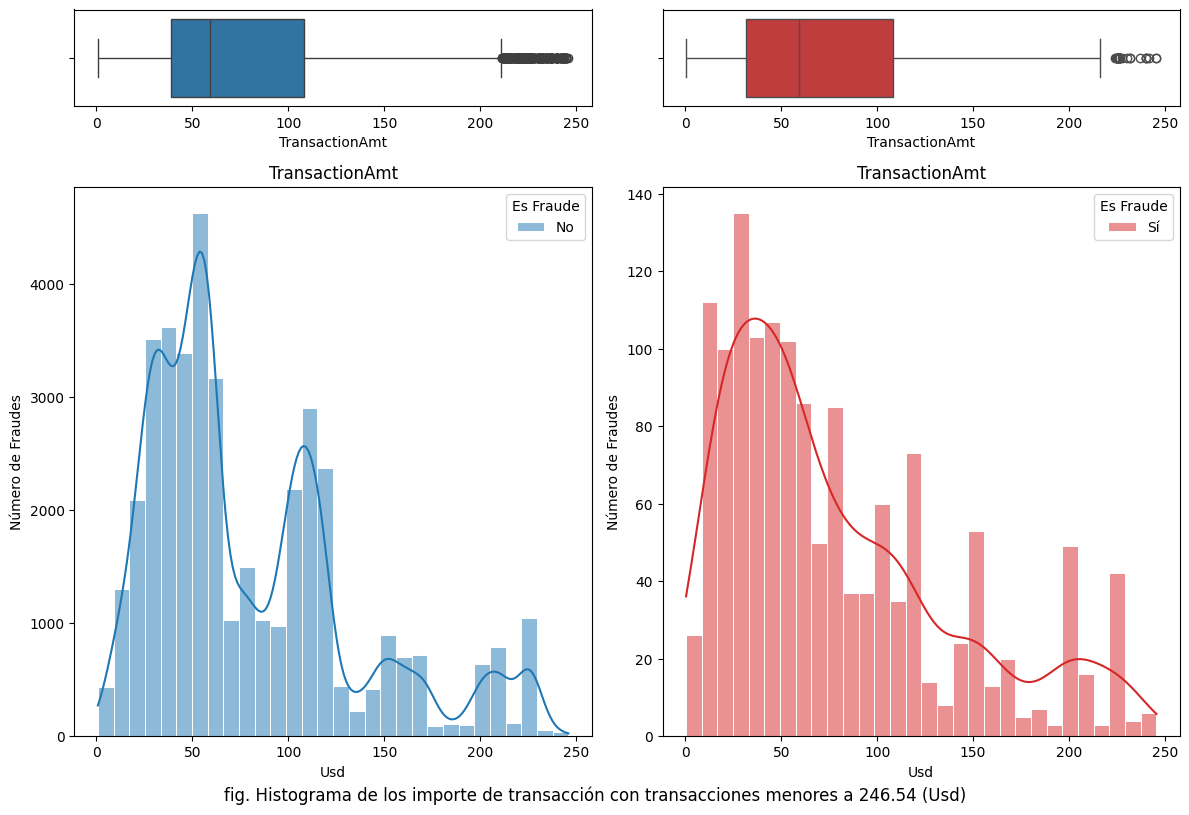

In [74]:
df_train_IQR =  df_train[df_train['TransactionAmt'] < limite_amt]
grafica_histo_boxplot(df_train_IQR,'TransactionAmt','Usd',"fig. Histograma de los importe de transacción con transacciones menores a " + str(round(limite_amt, 2))+" (Usd)" )
plt.savefig(base_dir + 'menor a primer quantil')

In [75]:
df_train['TransactionAmt'].describe()

count    47243.000000
mean       136.473947
std        276.125302
min          0.350000
25%         43.970000
50%         68.950000
75%        125.000000
max      31937.391000
Name: TransactionAmt, dtype: float64

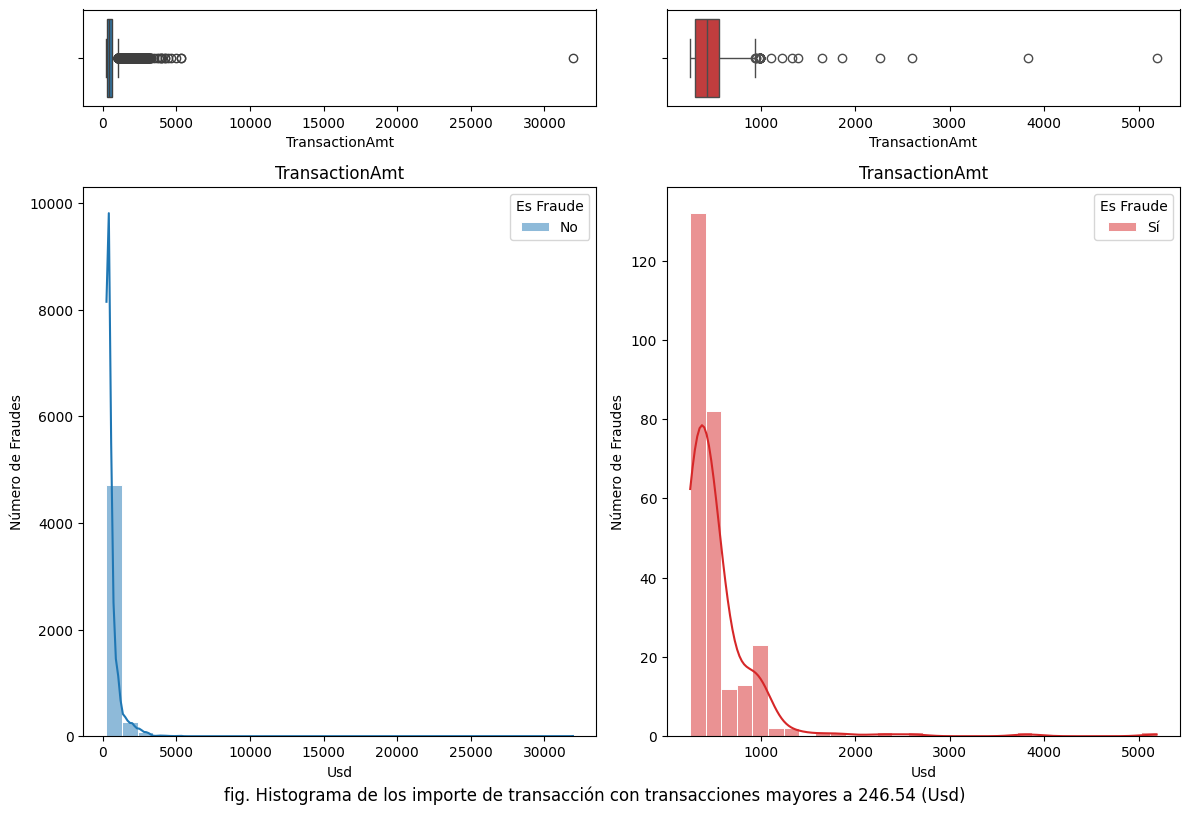

In [76]:
df_train_IQR =  df_train[df_train['TransactionAmt'] > limite_amt]
grafica_histo_boxplot(df_train_IQR,'TransactionAmt','Usd',"fig. Histograma de los importe de transacción con transacciones mayores a " + str(round(limite_amt, 2))+" (Usd)")
plt.savefig(base_dir + 'mayor a primer quantil')

**Observación:** Después de segmentar los datos utilizando el criterio de los intercuartiles, en la primera gráfica se evidencia una distribución mejorada aunque con sesgo hacia la izquierda. Por otro lado, en la segunda gráfica, donde se encuentran los datos restantes, se observa también una distribución sesgada hacia la izquierda, además de la presencia de datos atípicos. Por consiguiente, aplicaremos el criterio de separación intercuartil nuevamente a este segundo grupo de datos de datos de entrenamiento.

In [77]:
limite_amt_2 = calculo_quantile(df_train[ (df_train['TransactionAmt'] > limite_amt)],'TransactionAmt')

Primer Cuartil (Q1): 311.95
Tercer Cuartil (Q3): 592.095
Rango Intercuartil (IQR): 280.14500000000004
Límite Inferior: -108.2675000000001
Límite Superior: 1012.3125000000001


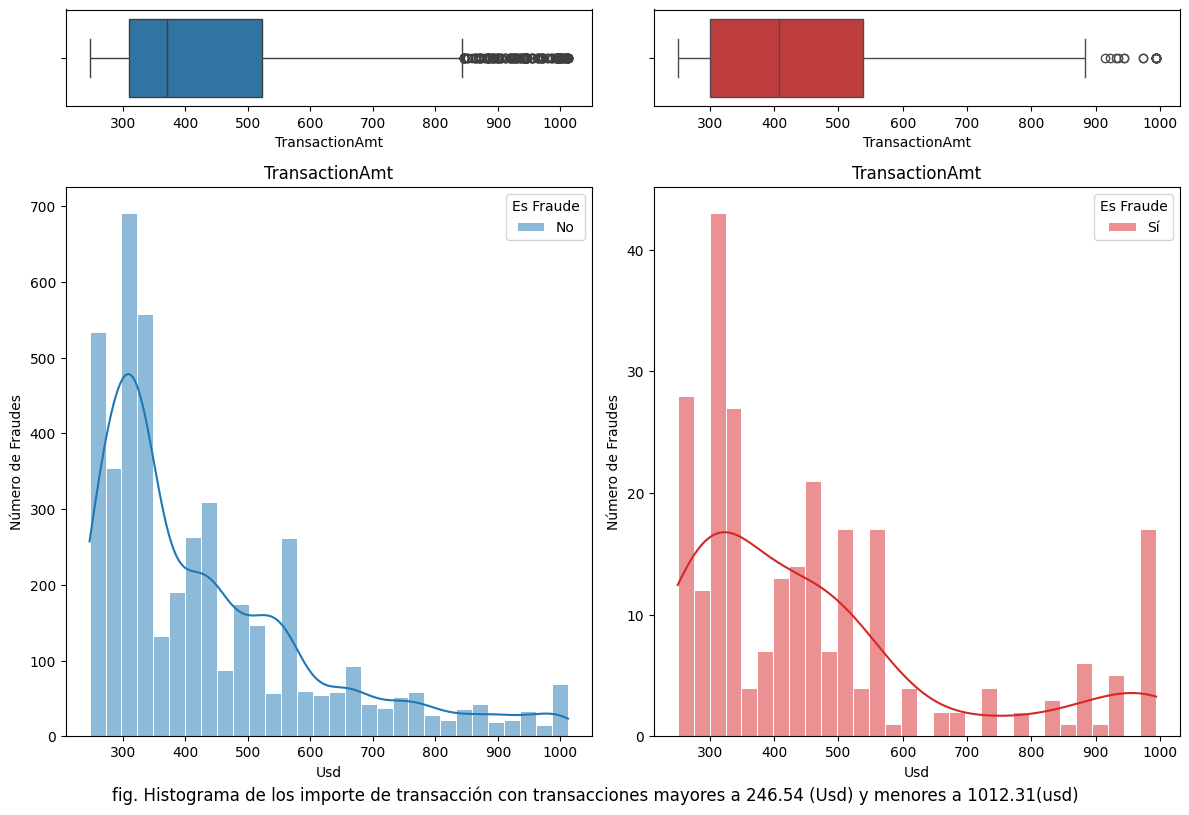

In [78]:
df_train_IQR = df_train[(df_train['TransactionAmt'] > limite_amt) & (df_train['TransactionAmt'] < limite_amt_2)]

grafica_histo_boxplot(df_train_IQR,'TransactionAmt','Usd',"fig. Histograma de los importe de transacción con transacciones mayores a " + str(round(limite_amt, 2))+" (Usd) y menores a " + str(round(limite_amt_2, 2)) + "(usd)" )
plt.savefig(base_dir + 'menor a segundo quantil y mayor al primer')

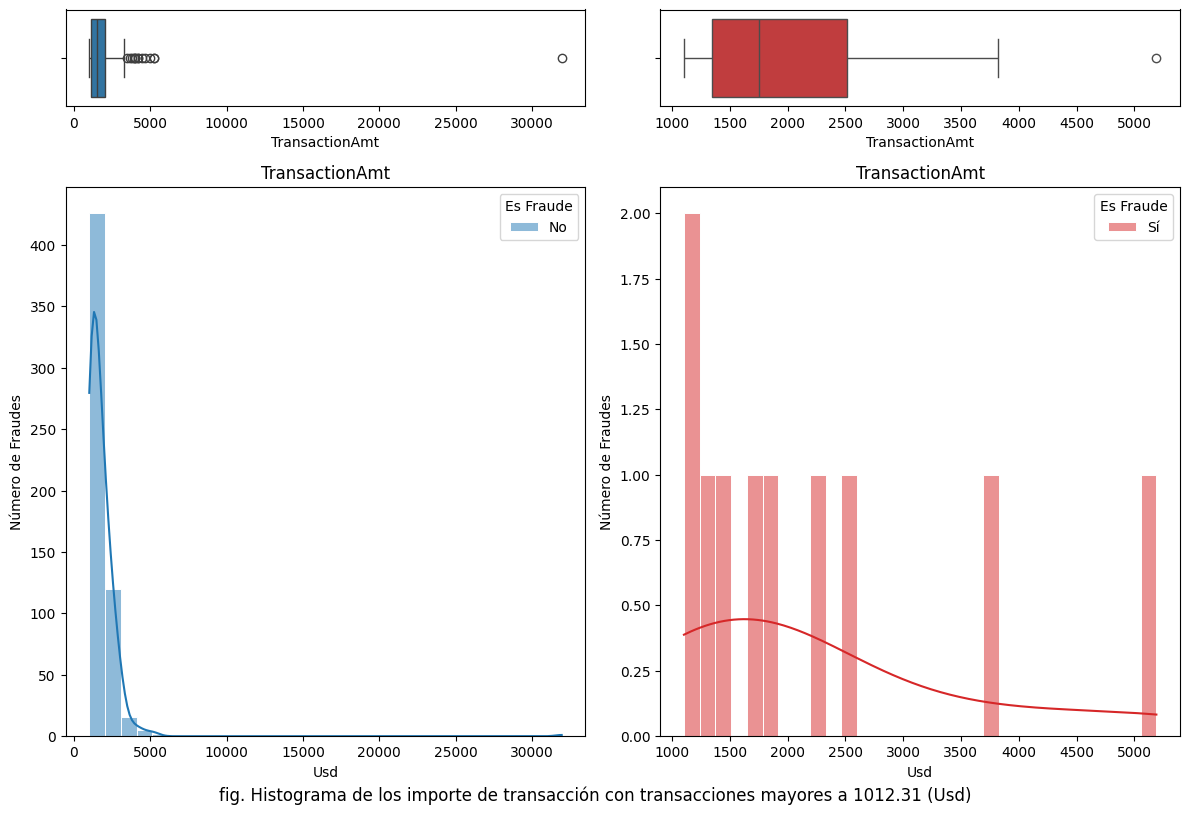

In [79]:
df_train_IQR = df_train[ (df_train['TransactionAmt'] >limite_amt_2
                          )]

grafica_histo_boxplot(df_train_IQR,'TransactionAmt','Usd',"fig. Histograma de los importe de transacción con transacciones mayores a " + str(round(limite_amt_2, 2))+" (Usd)")
plt.savefig(base_dir + 'mayor a segundo quantil')

In [80]:
df_train_R1 = df_train[df_train['TransactionAmt'] <limite_amt]
df_train_R1[['TransactionAmt']].describe()

TransactionAmt
count    41900.000000
mean        79.793022
std         53.909941
min          0.350000
25%         39.000000
50%         59.000000
75%        107.950000
max        245.990000

In [81]:
df_train_R2 =  df_train[(df_train['TransactionAmt'] > limite_amt) & (df_train['TransactionAmt'] < limite_amt_2)]
df_train_R2[['TransactionAmt']].describe()

TransactionAmt
count     4763.000000
mean       435.417615
std        180.233185
min        246.820000
25%        308.833500
50%        372.130000
75%        524.605000
max       1011.950000

In [82]:
df_train_R3 = df_train[df_train['TransactionAmt'] >limite_amt_2]
df_train_R3[['TransactionAmt']].describe()

TransactionAmt
count      580.000000
mean      1776.236140
std       1443.064752
min       1014.950000
25%       1136.382500
50%       1517.725000
75%       2064.450000
max      31937.391000

In [83]:
total = df_train_R1.shape[0]+df_train_R2.shape[0]+df_train_R3.shape[0]
print('Total de registro R1:', round(((df_train_R1.shape[0]/total)*100),2))
print('Total de registro R2:', round(((df_train_R2.shape[0]/total)*100),2))
print('Total de registro R3:', round(((df_train_R3.shape[0]/total)*100),2))

Total de registro R1: 88.69
Total de registro R2: 10.08
Total de registro R3: 1.23


In [84]:
df_train_R1['isFraud'].value_counts(normalize=True) * 100

isFraud
0    96.622912
1     3.377088
Name: proportion, dtype: float64

In [85]:
df_train_R2['isFraud'].value_counts(normalize=True) * 100

isFraud
0    94.499265
1     5.500735
Name: proportion, dtype: float64

In [86]:
df_train_R3['isFraud'].value_counts(normalize=True) * 100

isFraud
0    98.275862
1     1.724138
Name: proportion, dtype: float64

Observación

Por lo tanto tenemos los datos de entrenamiento en tres partes usando la columna de importe de pago de cada transacción (TransactionAmt).



| Rangos | Rangos (usd)  | % Registro | %No Fraude |  %Sí Fraude  |
| ------------ | ------------ | ------------ | ------------ |  ------------ |
|R1| 0 - 248    | 88,79|96.60 |3.39|
|R2| 248 - 999 | 9.93| 94.59|5.40|
|R3| > 999   | 1.28| 98.28|1.71|



**La tabla indica que el rango 2 presenta la proporción más alta de casos de fraude en comparación con los demás rangos. Para determinar si esta diferencia es simplemente el resultado del azar o si refleja una tendencia genuina, emplearemos la prueba A/B. Este análisis nos ayudará a responder a la pregunta sobre la significancia estadística de la disparidad observada en las proporciones de fraude entre los diferentes rangos.**

### **7.2.2 Hipótesis Nula: ¿La disparidad en las proporciones observada de fraude es producto del azar o es genuina?**
En esta sección, planteamos la hipótesis nula de que la disparidad en las proporciones observadas de fraude es simplemente el resultado del azar y no refleja una diferencia genuina. Para evaluar esta hipótesis, implementamos la prueba A/B entre los rangos 1 y 2, ya que estos dos segmentos contienen la mayor cantidad de registros. Este análisis nos permitirá determinar si existen diferencias estadísticamente significativas entre las proporciones de fraudes en estos dos rangos y, por ende, si la segmentación basada en el rango intercuartil tiene un impacto significativo en la detección de fraudes. **Esto nos permite saber si el rango 1 y 2 son diferentes estadisticamente.

In [87]:
hola =[0]*(df_train_R1[df_train_R1['isFraud']==1 ].shape[0]+df_train_R2[df_train_R2['isFraud']==1 ].shape[0])
len(hola)

1677

In [88]:
obs_pct_diff = 100*((df_train_R2[df_train_R2['isFraud']==1 ].shape[0]/df_train_R2.shape[0])-(df_train_R1[df_train_R1['isFraud']==1 ].shape[0]/df_train_R1.shape[0]))
print(f'Diferencia observada: {obs_pct_diff:.4f}%')
conversion = [0]*(df_train_R1[df_train_R1['isFraud']==0 ].shape[0]+df_train_R2[df_train_R2['isFraud']==0 ].shape[0])
conversion.extend([1]*(df_train_R1[df_train_R1['isFraud']==1 ].shape[0]+df_train_R2[df_train_R2['isFraud']==1 ].shape[0]))
conversion = pd.Series(conversion)
permu_diffs = [100* perm_fun(conversion,df_train_R2.shape[0],df_train_R1.shape[0]) for _ in range(1000)]


Diferencia observada: 2.1236%


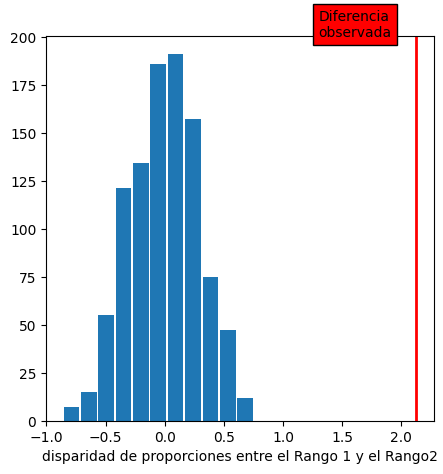

In [89]:
fig,ax= plt.subplots(figsize=(5,5))
ax.hist(permu_diffs,bins=11,rwidth=0.9)
ax.axvline(x=obs_pct_diff,color='red',lw=2)
ax.text(1.3,200,'Diferencia\nobservada',bbox={'facecolor':'red'})
ax.set_xlabel('disparidad de proporciones entre el Rango 1 y el Rango2')
plt.savefig(base_dir + 'hipotesis nula')

Conclusión: En la gráfica que muestra la disparidad de proporciones entre el rango 1 y el rango 2, se destaca que la línea roja, que representa el valor de disparidad entre ambos rangos, se encuentra fuera del histograma generado por azar. Esta observación sugiere que la disparidad no fue generada al azar, permitiéndonos concluir que existe una diferencia significativa entre los dos rangos.

**Teniendo en cuenta que la mayor cantidad de registros se encuentra en el rango 1, concentraremos nuestro análisis en esta categoría en la primera fase. Posteriormente, una vez completada esta etapa inicial, extenderemos el análisis para abarcar los demás rangos.

### **7.2.3 Prueba de Similitud entre las Distribuciones de importes con y sin Fraude en el Rango 1**

En esta sección, realizamos una prueba estadística para determinar si las distribuciones de importes de transacciones con y sin fraude son similares. Esta evaluación nos proporcionará información crucial sobre la existencia de patrones distintivos en los importes de las transacciones fraudulentas en comparación con las no fraudulentas.

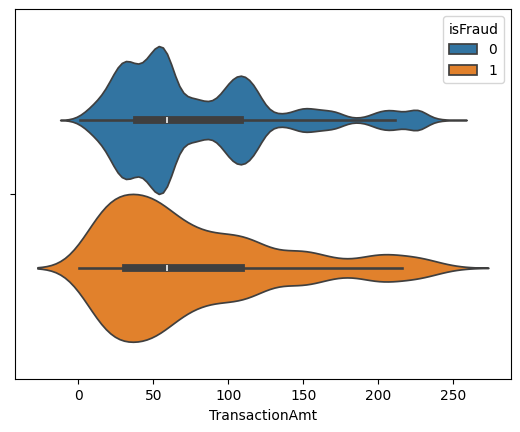

In [90]:
sns.violinplot(data=df_train_R1,x=df_train_R1['TransactionAmt'],hue='isFraud')
plt.savefig('prueba_similitud_fraude.png')

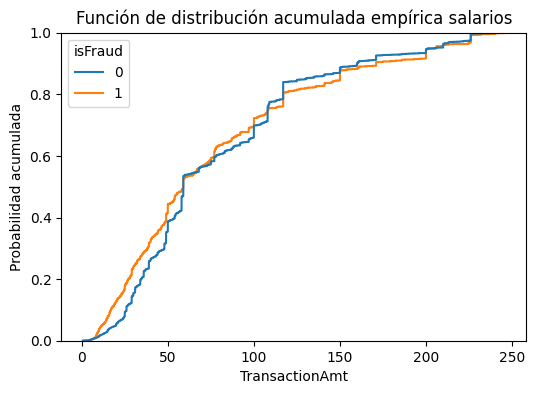

In [91]:

# Representación gráfica de las curvas ecdf
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
sns.ecdfplot(data=df_train_R1, x="TransactionAmt", hue='isFraud', ax=ax)
ax.set_title("Función de distribución acumulada empírica salarios")
ax.set_ylabel("Probabilidad acumulada");
plt.savefig('acumulacion.png')


In [92]:
from scipy.stats import ks_2samp

In [93]:
ks_2samp(
    df_train_R1.loc[df_train_R1['isFraud'] == 1, 'TransactionAmt'],
   df_train_R1.loc[df_train_R1['isFraud'] == 0, 'TransactionAmt']
)

KstestResult(statistic=0.09381400693272515, pvalue=6.381476286831378e-11, statistic_location=28.917, statistic_sign=1)


Observación:

El p-valor asociado a la prueba de Kolmogorov-Smirnov es notablemente bajo, específicamente 4.09e-14. Este valor de p es muy pequeño, lo que sugiere que la probabilidad de observar una distancia KS tan grande o mayor entre las distribuciones, suponiendo que provienen de la misma población, es extremadamente baja. Por lo tanto, se puede concluir con confianza que la hipótesis nula de que ambas muestras se originan en la misma distribución es rechazada. En otras palabras, existe suficiente evidencia estadística para afirmar que las distribuciones son diferentes y que estas diferencias no son simplemente el resultado de variaciones aleatorias. Este resultado proporciona una comprensión más profunda de las divergencias en el fenómeno analizado.

### **7.3 Columnas 'TransactionDT' Vs isFraud en el Rango1**
Analizamos la asociación entre la columna "TransactionDT", que representa los tiempos de cada transacción, y la columna de fraude. Este análisis incluye la evaluación de la distribución de los tiempos en relación con la presencia de fraudes.




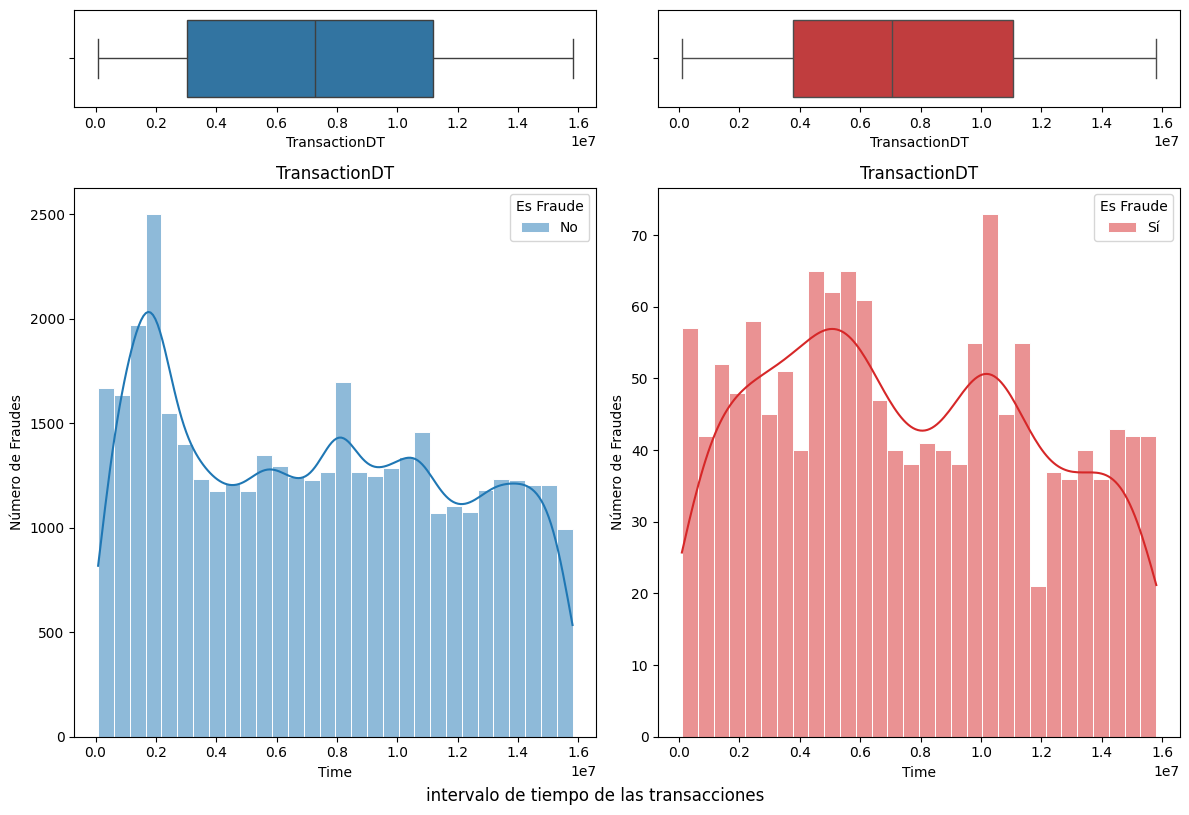

In [94]:
grafica_histo_boxplot(df_train_R1,'TransactionDT','Time',"intervalo de tiempo de las transacciones")
plt.tight_layout()
plt.savefig('dt-fraude')

In [95]:
df_train_R1[['TransactionDT']].describe()

TransactionDT
count   4.190000e+04
mean    7.353670e+06
std     4.603886e+06
min     8.646900e+04
25%     3.028981e+06
50%     7.260786e+06
75%     1.117906e+07
max     1.581021e+07

In [96]:
df_train_R1[['TransactionDT']][df_train_R1['isFraud'] == 0].describe().round(2)

TransactionDT
count       40485.00
mean      7348099.52
std       4608768.82
min         86469.00
25%       3015901.00
50%       7262887.00
75%      11195554.00
max      15810212.00

In [97]:
df_train_R1[['TransactionDT']][df_train_R1['isFraud'] == 1].describe().round(2)

TransactionDT
count        1415.00
mean      7513056.81
std       4460564.60
min        102188.00
25%       3776493.00
50%       7063147.00
75%      11071546.00
max      15801716.00

Observación:
 - Las media y la mediana son del mismo orden de magnitud.
 - Los Histograma muestran distribuciones uniforme en ambos casos

### **7.3.1 Prueba de Similitud entre las Distribuciones de Tiempo (TransactionDT) con y sin Fraude en el Rango 1**


En esta sección, realizamos una prueba estadística para determinar si las distribuciones de importes de tiempo con y sin fraude son similares. Esta evaluación nos proporcionará información crucial sobre la existencia de patrones distintivos en los importes de las transacciones fraudulentas en comparación con las no fraudulentas.

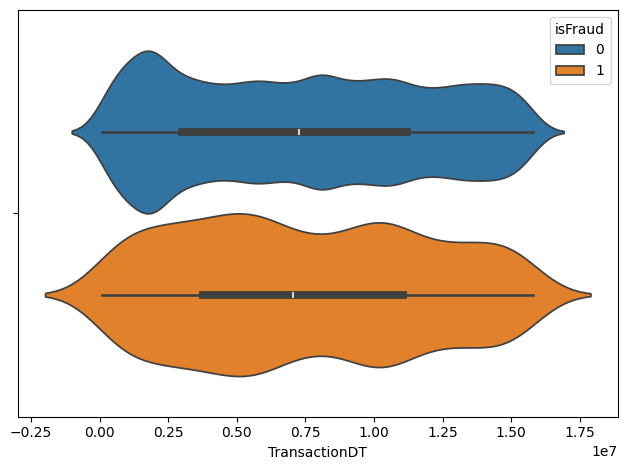

In [98]:
sns.violinplot(data=df_train_R1,x=df_train_R1['TransactionDT'],hue='isFraud')
plt.tight_layout()
plt.savefig('dt-box')

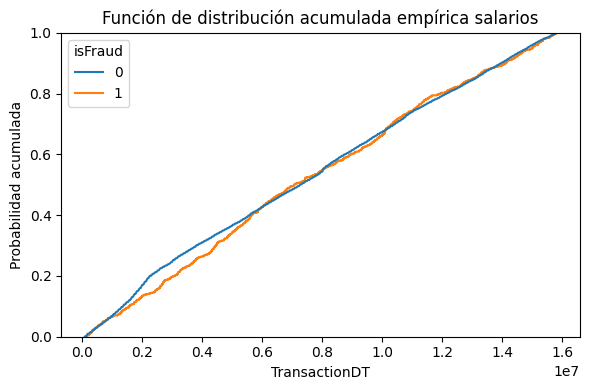

In [99]:

# Representación gráfica de las curvas ecdf
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
sns.ecdfplot(data=df_train_R1, x="TransactionDT", hue='isFraud', ax=ax)
ax.set_title("Función de distribución acumulada empírica salarios")
ax.set_ylabel("Probabilidad acumulada");
plt.tight_layout()
plt.savefig('dt-fraude-acumu')

In [100]:
ks_2samp(
    df_train_R1.loc[df_train_R1['isFraud'] == 1, 'TransactionDT'],
   df_train_R1.loc[df_train_R1['isFraud'] == 0, 'TransactionDT']
)

KstestResult(statistic=0.06401995940563426, pvalue=2.5843866666633258e-05, statistic_location=2418437, statistic_sign=-1)

Observaciones:
- Al considerar el p-valor, que es particularmente bajo (3.35e-06), llegamos a la conclusión de que las distribuciones son distintas y, por ende, podemos rechazar la hipótesis nula.

- Además, al observar las gráficas de las distribuciones acumuladas, notamos que estas siguen casi una línea recta. Este patrón sugiere que las distribuciones son casi uniformes, ya que la función de distribución acumulada (CDF) de una distribución uniforme debería incrementar de manera constante y lineal. La consistencia con esta forma lineal refuerza la evidencia de la uniformidad en las distribuciones analizadas.

### **7.4 Relación entre el Tiempo y los importes de las Transacciones**

En esta sección, exploraremos la posible relación entre el tiempo (TransactionDT) y los montos de las transacciones. Analizaremos si hay patrones discernibles en la relación temporal con los montos, lo que podría proporcionar información valiosa sobre el comportamiento de las transacciones a lo largo del tiempo en el conjunto de datos.

In [101]:
## Armamos un nuevo data Frame para mostrar mejor la categoria de fraude
valores_fraudes = {0:'No',1:'Sí'}
df_fraudes = df_train_R1[['isFraud','TransactionDT','TransactionAmt','ProductCD','DeviceType', 'DeviceInfo']].copy()
df_fraudes['isFraud'] = df_train_R1['isFraud'].replace(valores_fraudes)


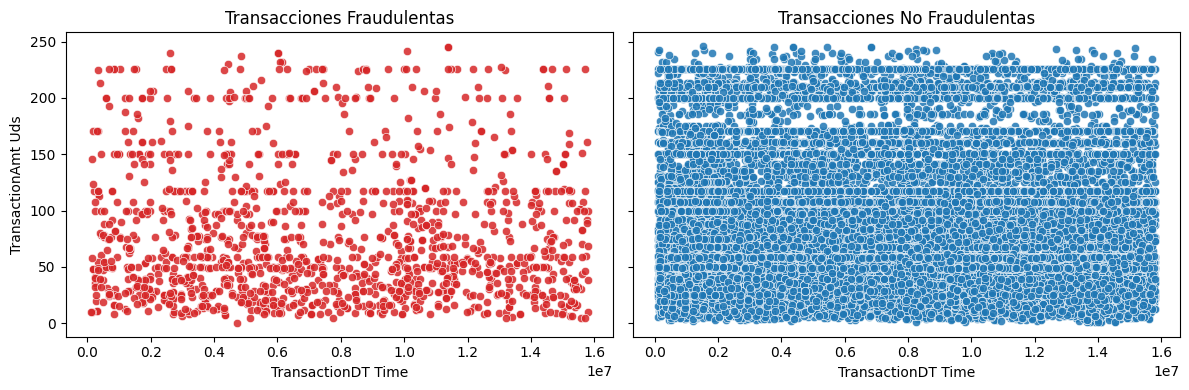

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un gráfico de dispersión con muestras aleatorias
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharey=True)

# Filtrar los datos por 'isFraud'
df_fraudes_si = df_train_R1[df_train_R1['isFraud'] == 1]  # Asumiendo que 'isFraud' es booleano
df_fraudes_no = df_train_R1[df_train_R1['isFraud'] == 0]  # Asumiendo que 'isFraud' es booleano

# Primer gráfico para 'isFraud' igual a Sí
sns.scatterplot(data=df_fraudes_si, x='TransactionDT', y='TransactionAmt', alpha=0.85, color='tab:red', ax=axs[0])
axs[0].set_xlabel('TransactionDT Time')
axs[0].set_ylabel('TransactionAmt Uds')
axs[0].set_title('Transacciones Fraudulentas')

# Segundo gráfico para 'isFraud' igual a No
sns.scatterplot(data=df_fraudes_no, x='TransactionDT', y='TransactionAmt',alpha=0.85, color='tab:blue', ax=axs[1])
axs[1].set_xlabel('TransactionDT Time')
axs[1].set_title('Transacciones No Fraudulentas')

# Ajustar el diseño
plt.tight_layout()
plt.savefig('transacciones_fraude.png')
plt.show()



In [103]:
correlacion = df_train_R1['TransactionAmt'].corr(df_train_R1['TransactionDT'])
correlacion

0.006217289239766133

In [104]:
correlacion = df_train_R1[df_train_R1['isFraud'] == 0]['TransactionAmt'].corr(df_train_R1[df_train_R1['isFraud']==0]['TransactionDT'])
correlacion

0.007651741086835737

In [105]:
correlacion = df_train_R1[df_train_R1['isFraud'] == 1]['TransactionAmt'].corr(df_train_R1[df_train_R1['isFraud']==1]['TransactionDT'])
correlacion

-0.031121778825197174

la correlacion entre los importes y el tiempo:
- Datos total: 0.006
- Con fraude -0.019
- sin fraude 0.07
Los valores de correlación son casi cero en todos los casos por lo tanto no hay correlación entre el importe y el tiempo

In [106]:
import statsmodels.api as sm

In [107]:
import pandas as pd
import statsmodels.api as sm
import numpy as np


# Ajustar el modelo de regresión lineal
X = sm.add_constant(df_train_R1['TransactionAmt'])  # Agregar la columna de intercepto
model = sm.OLS(df_train_R1['TransactionDT'], X).fit()

# Obtener los resultados del modelo
results = model.summary()
print(results)

                            OLS Regression Results                            
Dep. Variable:          TransactionDT   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.620
Date:                Mon, 17 Jun 2024   Prob (F-statistic):              0.203
Time:                        11:32:18   Log-Likelihood:            -7.0230e+05
No. Observations:               41900   AIC:                         1.405e+06
Df Residuals:                   41898   BIC:                         1.405e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           7.311e+06   4.02e+04    181.

observación: Dado que el p-valor (0.162) es mayor que el nivel de significancia comúnmente utilizado (por ejemplo, 0.05), no hay evidencia suficiente para rechazar la hipótesis nula. En otras palabras, no hay suficiente evidencia estadística para afirmar que el coeficiente de TransactionAmt es diferente de cero en esta muestra de datos y bajo este modelo particular

### **7.5 Columna ProductCD Vs isFraud**

<Axes: xlabel='ProductCD', ylabel='count'>

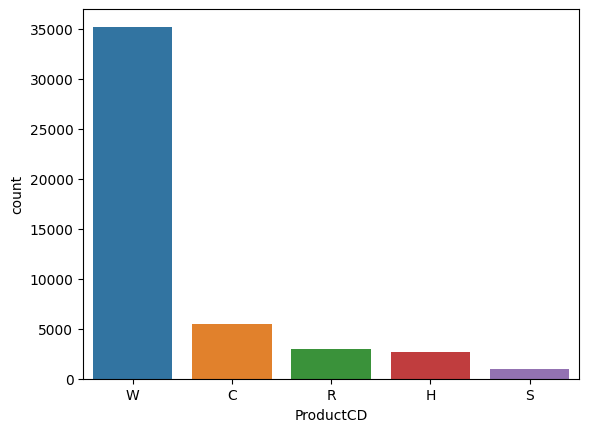

In [108]:
### código de producto, el producto de cada transacción
sns.color_palette("bright")
Numero_ProductCD =  df_train['ProductCD'].value_counts()
sns.barplot(x=Numero_ProductCD.index,y=Numero_ProductCD,hue=Numero_ProductCD.index)

<ipython-input-109-f033958752b8>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_R1['ProductCD'] = ordered_product_cd


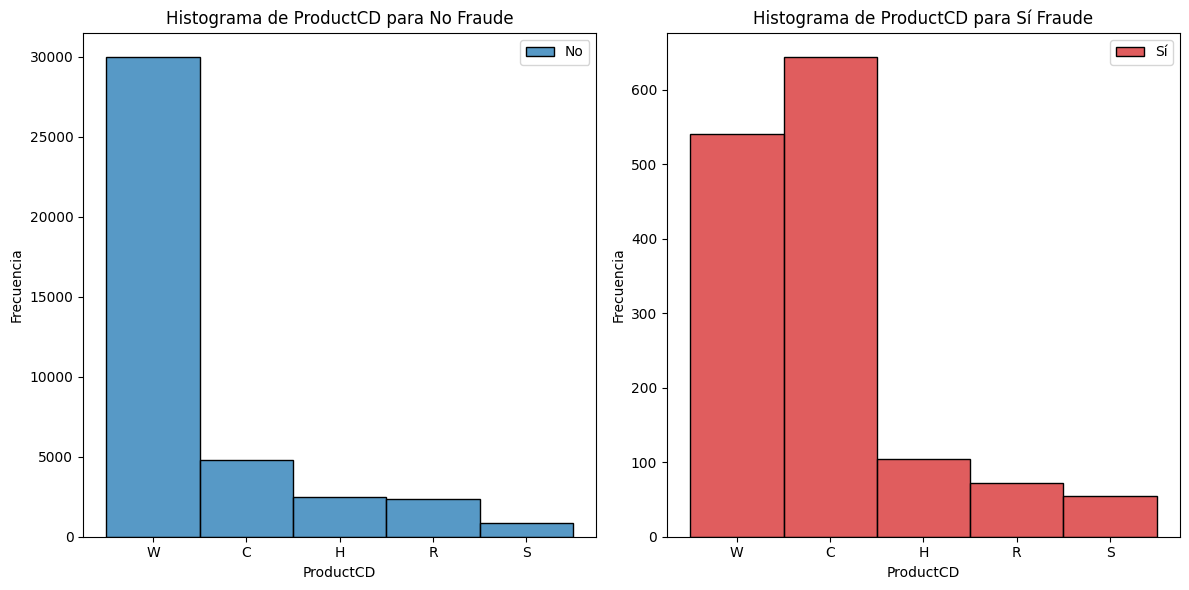

In [109]:

# Ejemplo de DataFrame df_train_R1
# Supongamos que df_train_R1 ya está definido con las columnas 'isFraud' y 'ProductCD'
# df_train_R1 = ...

# Paso 1: Calcular las frecuencias de 'ProductCD'
freq_no_fraud = df_train_R1[df_train_R1['isFraud'] == 0]['ProductCD'].value_counts()
freq_fraud = df_train_R1[df_train_R1['isFraud'] == 1]['ProductCD'].value_counts()

# Paso 2: Combinar y ordenar los valores únicos de 'ProductCD'
total_freq = (freq_no_fraud + freq_fraud).sort_values(ascending=False)

# Paso 3: Asignar categorías ordenadas a 'ProductCD'
ordered_product_cd = pd.Categorical(df_train_R1['ProductCD'], categories=total_freq.index, ordered=True)
df_train_R1['ProductCD'] = ordered_product_cd

# Paso 4: Graficar los histogramas
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(12, 6))
sns.histplot(df_train_R1[df_train_R1['isFraud'] == 0], x='ProductCD', ax=axs[0], color='tab:blue', label='No')
sns.histplot(df_train_R1[df_train_R1['isFraud'] == 1], x='ProductCD', ax=axs[1], color='tab:red', label='Sí')

# Configurar leyendas y títulos
axs[0].legend()
axs[1].legend()
axs[0].set_title('Histograma de ProductCD para No Fraude')
axs[0].set_xlabel('ProductCD')
axs[0].set_ylabel('Frecuencia')
axs[1].set_title('Histograma de ProductCD para Sí Fraude')
axs[1].set_xlabel('ProductCD')
axs[1].set_ylabel('Frecuencia')
plt.tight_layout()
plt.savefig('productCD.png')
plt.show()

plt.show()


#### se observa que los ProductCD con el codigo "C" y "W", tienen una mayor numero de fraude en el Rango 1

### **7.6 Columna DeviceType Vs isFraud**

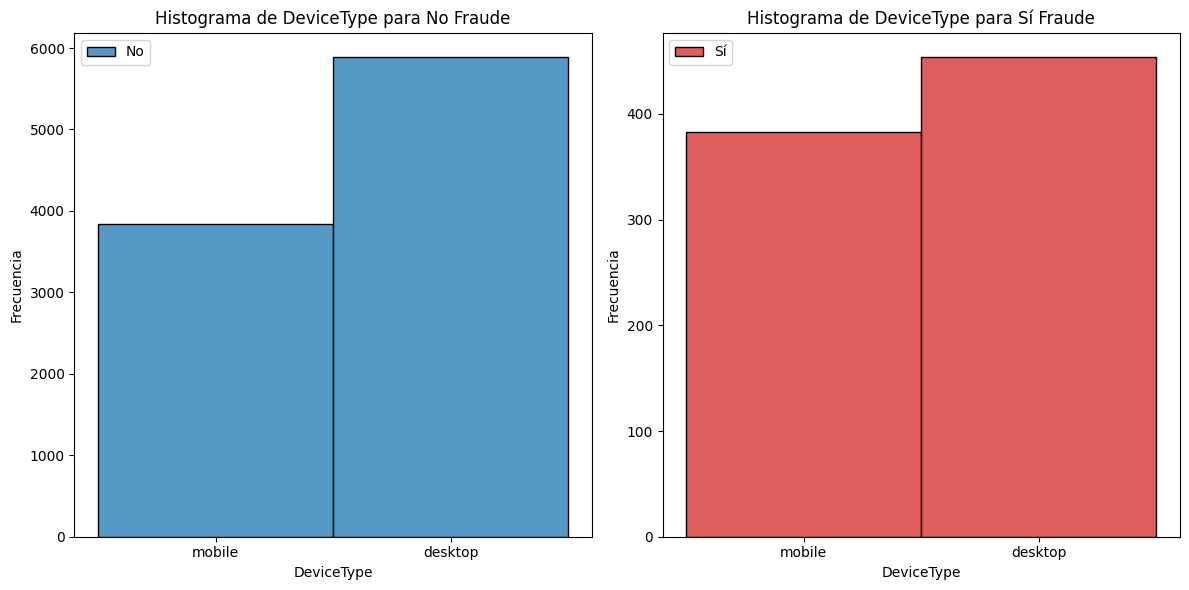

In [110]:
fig, axs = plt.subplots(1,2,tight_layout=True, figsize=(12,6))
sns.histplot(df_train_R1[df_train_R1['isFraud'] ==0 ], x='DeviceType', ax=axs[0], color='tab:blue',label='No')
sns.histplot(df_train_R1[df_train_R1['isFraud'] ==1 ], x='DeviceType', ax=axs[1], color='tab:red',label='Sí')
axs[0].legend()
axs[1].legend()
axs[0].set_title('Histograma de DeviceType para No Fraude')
axs[0].set_xlabel('DeviceType')
axs[0].set_ylabel('Frecuencia')
axs[1].set_title('Histograma de DeviceType para Sí Fraude')
axs[1].set_xlabel('DeviceType')
axs[1].set_ylabel('Frecuencia')
plt.tight_layout()
plt.savefig('devide.png')
plt.show()

#### Los equipos de escritorio tienen mayor números de fraude que los moviles

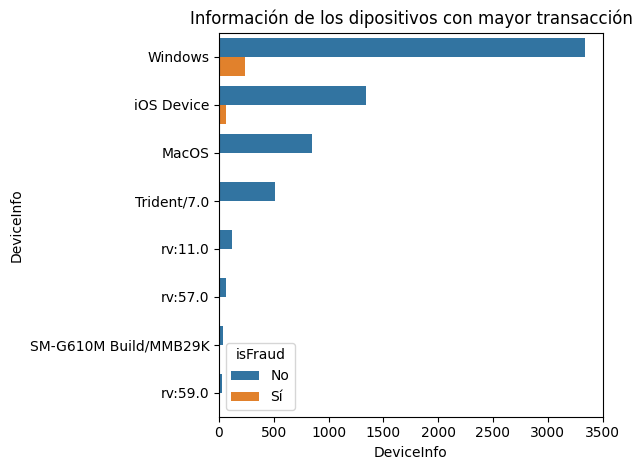

In [111]:
Numero_DeviceInfo =  df_fraudes[['DeviceInfo','isFraud']].value_counts(sort=True).head(10)
resultados = Numero_DeviceInfo.index.get_level_values(1)
sns.barplot(y=Numero_DeviceInfo.index.get_level_values(0),x=Numero_DeviceInfo, hue=resultados)
plt.title('Información de los dipositivos con mayor transacción')
plt.xlabel('DeviceInfo')
plt.tight_layout()
plt.savefig('info.png')
plt.show()

#### Los dispositivos con windows u ios son lo que tienen mayor número de fraude

## **8. Análisis Multivariante**

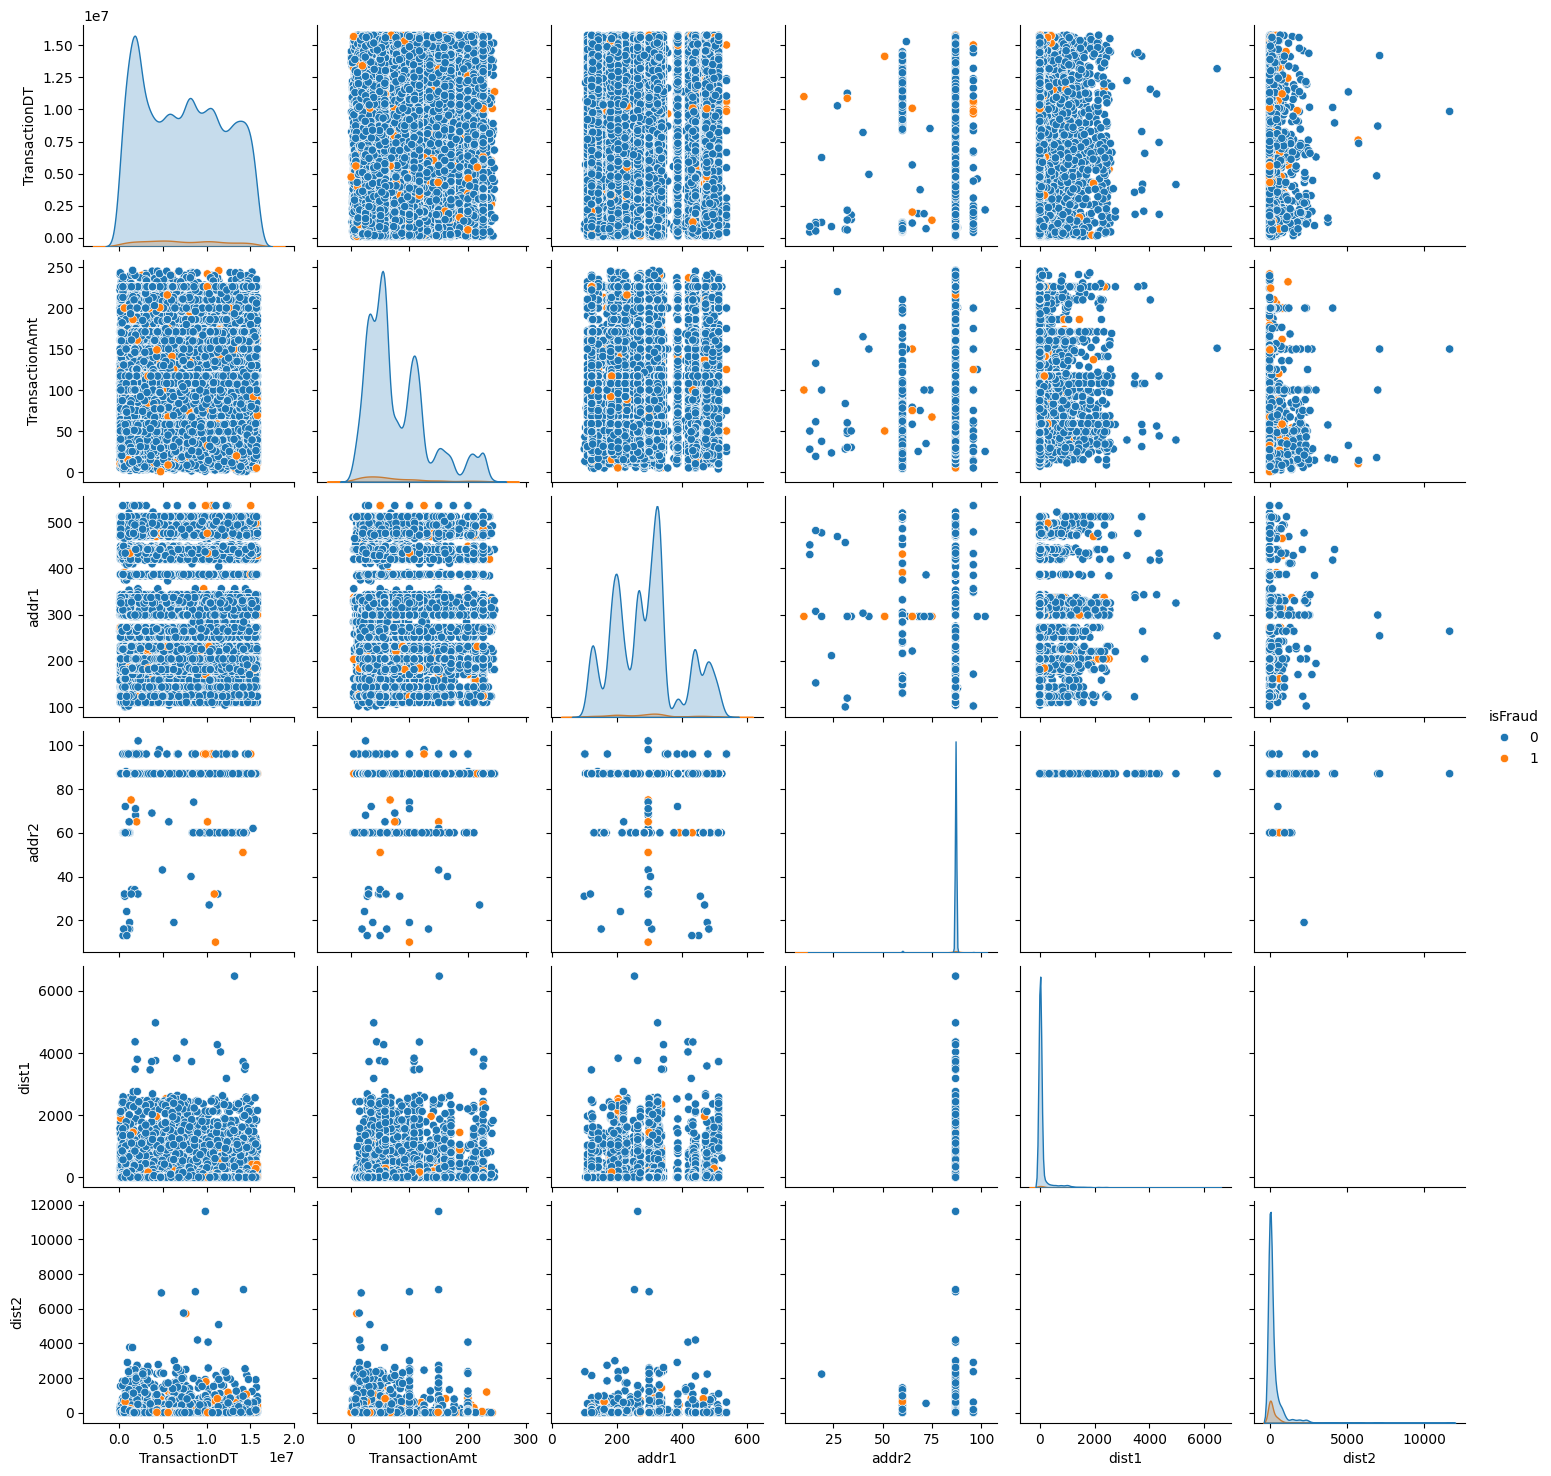

In [112]:
sns.pairplot(df_train_R1, hue='isFraud')

## 9.Modelo de Entrenamiento del Rango 1

### **9.1.Valores Nulos**

Se elimnaran las columnas que posean un alto porcentaje de datos faltantes.

In [113]:
## Porcentaje de valores nulos
null_percentages = (df_train_R1.isnull().sum() / len(df_train_R1)) * 100
print(round(null_percentages,2))

isFraud            0.00
TransactionDT      0.00
TransactionAmt     0.00
ProductCD          0.00
addr1             12.42
addr2             12.42
dist1             59.97
dist2             93.22
P_emaildomain     16.60
R_emaildomain     75.35
DeviceType        74.77
DeviceInfo        79.04
dtype: float64


Eliminamos las columnas que tienen un alto porcentaje de valores faltantes
- dist2
- R_emaildomain   
- DeviceType        
- DeviceInfo    

In [114]:
df_train_R1 = df_train_R1.drop(['dist2', 'R_emaildomain', 'DeviceType', 'DeviceInfo'], axis=1)


In [115]:
df_train_R1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41900 entries, 542017 to 166626
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   isFraud         41900 non-null  int64   
 1   TransactionDT   41900 non-null  int64   
 2   TransactionAmt  41900 non-null  float64 
 3   ProductCD       41900 non-null  category
 4   addr1           36696 non-null  float64 
 5   addr2           36696 non-null  float64 
 6   dist1           16771 non-null  float64 
 7   P_emaildomain   34943 non-null  object  
dtypes: category(1), float64(4), int64(2), object(1)
memory usage: 2.6+ MB


In [116]:
df_train_R1.isnull().sum()

isFraud               0
TransactionDT         0
TransactionAmt        0
ProductCD             0
addr1              5204
addr2              5204
dist1             25129
P_emaildomain      6957
dtype: int64

##

### 9.2 Imputar datos addr1 y addr2

In [117]:
imputer =SimpleImputer(strategy='most_frequent')

In [118]:
df_train_R1[[ 'addr1', 'addr2', 'dist1',
       'P_emaildomain']]= imputer.fit_transform(df_train_R1[[ 'addr1', 'addr2', 'dist1',
       'P_emaildomain']])

In [119]:
df_train_R1.isnull().sum()

isFraud           0
TransactionDT     0
TransactionAmt    0
ProductCD         0
addr1             0
addr2             0
dist1             0
P_emaildomain     0
dtype: int64

### 9.3 Dividir en variables categóricas y numéricas

In [120]:
## Separamos las variables y el target
X = df_train_R1.drop(['isFraud'],axis=1).copy()
y= df_train_R1['isFraud']

In [121]:
y.shape

(41900,)

In [122]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41900 entries, 542017 to 166626
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   TransactionDT   41900 non-null  int64   
 1   TransactionAmt  41900 non-null  float64 
 2   ProductCD       41900 non-null  category
 3   addr1           41900 non-null  object  
 4   addr2           41900 non-null  object  
 5   dist1           41900 non-null  object  
 6   P_emaildomain   41900 non-null  object  
dtypes: category(1), float64(1), int64(1), object(4)
memory usage: 2.3+ MB


In [123]:
num_atributos = ['TransactionDT', 'TransactionAmt']
cat_atributos = ['addr1', 'addr2', 'dist1','ProductCD','P_emaildomain']

In [124]:
# Codificación one-hot para variables categóricas
encoder = OneHotEncoder(drop='first')
encoder.fit(X[cat_atributos])
encoded_data = encoder.transform(X[cat_atributos]).toarray()

df_encoded  = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out())
X_encode = pd.concat([X.reset_index(drop=True),df_encoded],axis=1)

In [125]:
X_encode.shape

(41900, 1407)

In [126]:
# Asumiendo que 'encoder' ya ha sido ajustado a tus datos
original_categories = encoder.categories_

# Imprimir las categorías originales
for i, attribute_categories in enumerate(original_categories):
    print(f"Atributo {cat_atributos[i]}: {attribute_categories}")

Atributo addr1: [100.0 102.0 104.0 106.0 110.0 119.0 122.0 123.0 126.0 130.0 134.0 141.0
 143.0 148.0 152.0 155.0 157.0 158.0 161.0 167.0 170.0 171.0 177.0 181.0
 184.0 191.0 193.0 194.0 199.0 202.0 203.0 204.0 205.0 208.0 211.0 216.0
 220.0 221.0 225.0 226.0 231.0 239.0 242.0 247.0 251.0 253.0 254.0 258.0
 259.0 264.0 269.0 272.0 275.0 284.0 296.0 299.0 300.0 303.0 305.0 307.0
 308.0 310.0 315.0 321.0 324.0 325.0 327.0 330.0 332.0 337.0 343.0 348.0
 349.0 353.0 356.0 373.0 375.0 384.0 385.0 386.0 387.0 391.0 404.0 408.0
 410.0 411.0 418.0 420.0 428.0 430.0 431.0 432.0 433.0 436.0 441.0 444.0
 448.0 451.0 452.0 456.0 465.0 469.0 472.0 476.0 477.0 479.0 482.0 485.0
 486.0 492.0 494.0 498.0 499.0 502.0 507.0 508.0 511.0 512.0 520.0 522.0
 536.0]
Atributo addr2: [10.0 13.0 16.0 19.0 24.0 27.0 31.0 32.0 34.0 40.0 43.0 51.0 60.0 62.0
 65.0 68.0 69.0 71.0 72.0 74.0 75.0 87.0 88.0 96.0 98.0 102.0]
Atributo dist1: [0.0 1.0 2.0 ... 4356.0 4966.0 6466.0]
Atributo ProductCD: ['C' 'H' 'R' 'S' 'W']

In [127]:
# Escalado para varibles numérica
scaler = StandardScaler()
scaler.fit(X_encode[num_atributos])
X_encode[num_atributos] = scaler.transform(X_encode[num_atributos])

In [128]:
X_encode.drop(cat_atributos,axis=1,inplace=True)

In [129]:
X_encode.shape

(41900, 1402)

In [130]:
X_encode.select_dtypes(include='object').columns

Index([], dtype='object')

### Balancear datos

In [131]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Supongamos que df es tu DataFrame original y 'isFraud' es la columna objetivo
# df = ...

# Separar características (X) y la variable objetivo (y)


# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_encode, y, test_size=0.3, random_state=42, stratify=y)

# Aplicar SMOTE para balancear el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Verificar la distribución después de aplicar SMOTE
print("Distribución de la variable objetivo antes de SMOTE:")
print(y_train.value_counts())

print("\nDistribución de la variable objetivo después de SMOTE:")
print(y_train_balanced.value_counts())

df_train_balanced = pd.concat([pd.DataFrame(X_train_balanced, columns=X.columns), pd.DataFrame(y_train_balanced, columns=['isFraud'])], axis=1)




Distribución de la variable objetivo antes de SMOTE:
isFraud
0    28340
1      990
Name: count, dtype: int64

Distribución de la variable objetivo después de SMOTE:
isFraud
0    28340
1    28340
Name: count, dtype: int64


<ipython-input-132-122a3321f18a>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fraude, x='isFraud', y='count', palette=['tab:blue', 'tab:red'], ax=ax)


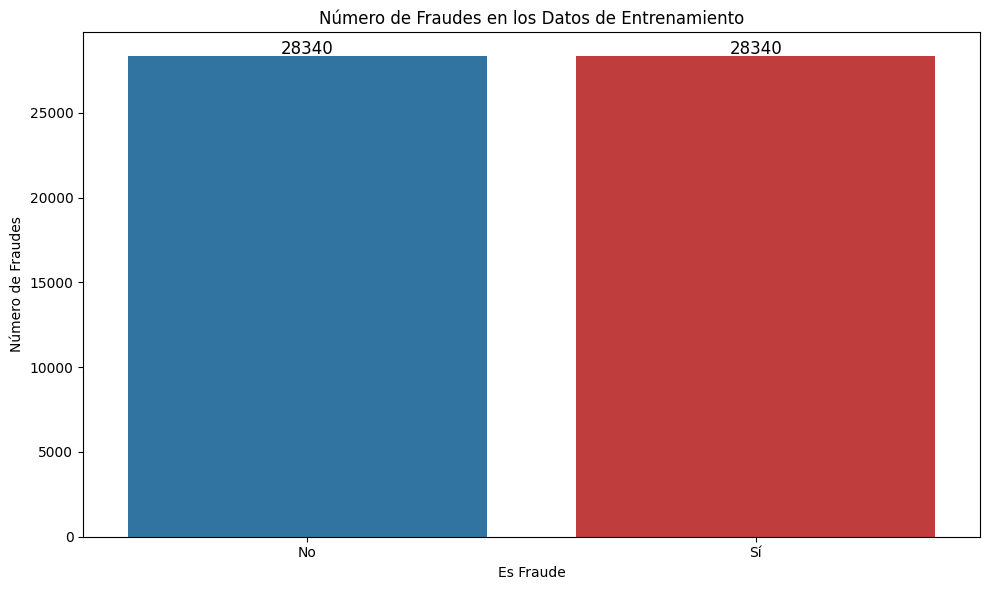

In [132]:


# Calcular los números de fraudes en los datos de entrenamiento
Numero_fraude = df_train_balanced['isFraud'].value_counts()
df_fraude = pd.DataFrame(Numero_fraude).rename(index={0: 'No', 1: 'Sí'}).reset_index()
df_fraude.columns = ['isFraud', 'count']  # Renombrar columnas para usar en seaborn

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(10, 6))

# Crear el gráfico de barras
sns.barplot(data=df_fraude, x='isFraud', y='count', palette=['tab:blue', 'tab:red'], ax=ax)

# Etiquetas y título
ax.set_ylabel('Número de Fraudes')
ax.set_title('Número de Fraudes en los Datos de Entrenamiento')
ax.set_xlabel('Es Fraude')

# Añadir etiquetas a las barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

# Ajustar el diseño para que no se recorten elementos
plt.tight_layout()

# Guardar la figura
plt.savefig('balance_datos_2.png')  # Asegúrate de definir base_dir o cambiar el path según sea necesario

# Mostrar la figura
plt.show()


### 9.5 Entrenamiento del modelo

In [133]:
X_train.shape

(29330, 1402)

In [134]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42,max_depth=40)
rf_model.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(max_depth=40, random_state=42)

In [135]:
## Predición con los datos de entrenamiento
predicciones_train = rf_model.predict(X_train_balanced)

accuracy_rf = accuracy_score(y_train_balanced, predicciones_train)
print(f'Precisión del RandomForest: {accuracy_rf}')

Precisión del RandomForest: 0.9324629498941426


In [136]:
## Predicción con los datos de evaluación
predicciones = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, predicciones)
print(f'Precisión del RandomForest: {accuracy_rf}')

Precisión del RandomForest: 0.8857597454256165


In [137]:
!pip install graphviz
!pip install pydotplus


In [138]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
import graphviz
import pydotplus
from IPython.display import Image


In [139]:

aucs = []

for i in range(10, 201, 20):
    rf = RandomForestClassifier(n_estimators=i, random_state=42)
    rf.fit(X_train_balanced, y_train_balanced)  # Ajustar el modelo en cada iteración

    y_pred = rf.predict_proba(X_test)[:, 1]  # Predecir usando el modelo ajustado
    auc = roc_auc_score(y_test, y_pred)
    print('%s -> %.3f' % (i, auc))
    aucs.append(auc)



10 -> 0.750
30 -> 0.774
50 -> 0.774
70 -> 0.776
90 -> 0.776
110 -> 0.778
130 -> 0.779
150 -> 0.780
170 -> 0.780
190 -> 0.780


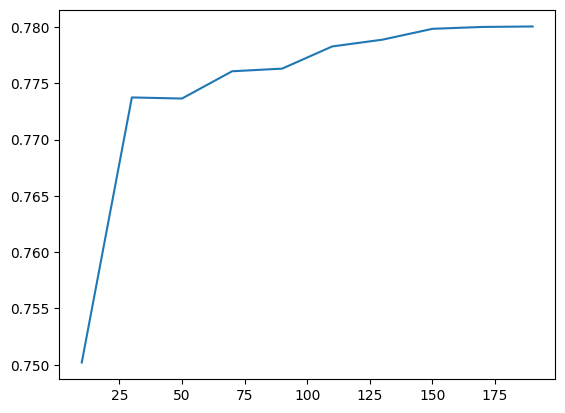

In [140]:
plt.plot(range(10,201,20), aucs)

Podemos ver que despues de n_estimators = 75 no hay cambios apreciables en auc, por lo tanto es un buen valor para el modelo

In [141]:
all_aucs = {}

for depth in [30,40,50,60]:
    print('depth: %s' % depth)
    aucs = []

    for i in range(10,150,20):
        rf = RandomForestClassifier(n_estimators=i, max_depth=depth, random_state=42)
        rf.fit(X_train_balanced, y_train_balanced)
        y_pred = rf.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred)
        print('%s -> %.3f' % (i, auc))
        aucs.append(auc)
    all_aucs[depth] = aucs

depth: 30
10 -> 0.750
30 -> 0.759
50 -> 0.763
70 -> 0.763
90 -> 0.765
110 -> 0.767
130 -> 0.766
depth: 40
10 -> 0.759
30 -> 0.767
50 -> 0.772
70 -> 0.774
90 -> 0.776
110 -> 0.776
130 -> 0.775
depth: 50
10 -> 0.768
30 -> 0.773
50 -> 0.777
70 -> 0.777
90 -> 0.777
110 -> 0.777
130 -> 0.779
depth: 60
10 -> 0.778
30 -> 0.781
50 -> 0.783
70 -> 0.786
90 -> 0.786
110 -> 0.786
130 -> 0.786


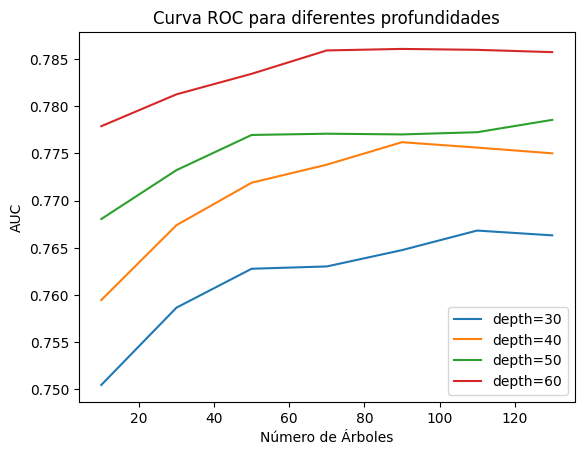

In [142]:
num_trees = list(range(10,150,20))
plt.plot(num_trees, all_aucs[30], label='depth=30')
plt.plot(num_trees, all_aucs[40], label='depth=40')
plt.plot(num_trees, all_aucs[50], label='depth=50')
plt.plot(num_trees, all_aucs[60], label='depth=60')
plt.xlabel('Número de Árboles')
plt.ylabel('AUC')
plt.title('Curva ROC para diferentes profundidades')
plt.legend()


depth = 40 es el mejor valor para el modelo

In [143]:
all_aucs = {}
for m in [1,2,3]:
    print('min_samples_leaf: %s' % m)
    aucs = []
    for i in range(10,110,20):
        rf = RandomForestClassifier(n_estimators=i, max_depth=40,
        min_samples_leaf=m, random_state=1)
        rf.fit(X_train_balanced, y_train_balanced)
        y_pred = rf.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred)
        print('%s -> %.3f' % (i, auc))
        aucs.append(auc)
    all_aucs[m] = aucs
    print()

min_samples_leaf: 1
10 -> 0.760
30 -> 0.769
50 -> 0.772
70 -> 0.772
90 -> 0.773

min_samples_leaf: 2
10 -> 0.736
30 -> 0.750
50 -> 0.754
70 -> 0.755
90 -> 0.756

min_samples_leaf: 3
10 -> 0.746
30 -> 0.752
50 -> 0.751
70 -> 0.751
90 -> 0.752



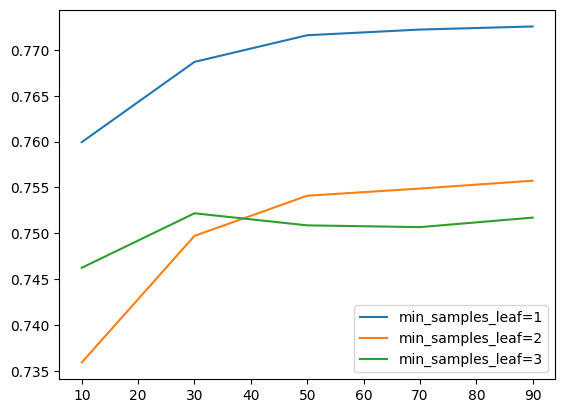

In [144]:
num_trees = list(range(10,110,20))
plt.plot(num_trees, all_aucs[1], label='min_samples_leaf=1')
plt.plot(num_trees, all_aucs[2], label='min_samples_leaf=2')
plt.plot(num_trees, all_aucs[3], label='min_samples_leaf=3')

plt.legend()

El gráfico nos indica que min_samples=1 es el mejor valor

In [145]:
from sklearn.model_selection import cross_val_score

min_samples_leaf_values = [1,2,3]
results = []
for value in min_samples_leaf_values:
    rf = RandomForestClassifier(n_estimators=60, min_samples_leaf=value, random_state=42, max_depth=40)
    # Evaluar utilizando cross_val_score con AUC-ROC
    scores = cross_val_score(rf, X_train_balanced, y_train_balanced, cv=5, scoring='roc_auc')
    results.append((value, np.mean(scores), np.std(scores)))
for value, mean_score, std_dev in results:
    print(f'min_samples_leaf={value} -> Mean AUC-ROC: {mean_score:.3f}, Std Dev: {std_dev:.3f}')

min_samples_leaf=1 -> Mean AUC-ROC: 0.959, Std Dev: 0.006
min_samples_leaf=2 -> Mean AUC-ROC: 0.919, Std Dev: 0.006
min_samples_leaf=3 -> Mean AUC-ROC: 0.905, Std Dev: 0.007


Utilizamos validacion cruzada para corroborar que que min_samples_leaf=1 es el mejor valor

Por lo tanto los mejores valores son:
- max_depth=40
- min_samples_leaf=1
- n_estimators = 60

In [146]:
rf_model = RandomForestClassifier(n_estimators=60, max_depth=40, min_samples_leaf=1,random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(max_depth=40, n_estimators=60, random_state=42)

In [147]:
## Predicción con los datos de evaluación
predicciones = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, predicciones)
print(f'Precisión del RandomForest: {accuracy_rf}')

Precisión del RandomForest: 0.8821002386634845


In [148]:
y_pred = rf_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
print('-> %.3f' % ( auc))

-> 0.774


### Conclusión

El modelo desarrollado demuestra un rendimiento sólido en la tarea de clasificación. Evaluamos su capacidad de separación y precisión en los conjuntos de datos de entrenamiento y prueba, obteniendo los siguientes resultados:

- **AUC en Datos de Test**: El modelo alcanzó un AUC de 0.78 en el conjunto de datos de test, lo que indica una buena capacidad para distinguir entre las clases objetivo. El AUC (Area Under the Curve) mide la capacidad del modelo para separar los valores positivos y negativos, y un valor de 0.78 sugiere que el modelo está funcionando correctamente en términos de clasificación.

- **Precisión en Datos de Entrenamiento**: La precisión del modelo en los datos de entrenamiento es excepcionalmente alta, alcanzando el 93%. Esto muestra que el modelo tiene un alto rendimiento al clasificar correctamente las instancias en los datos sobre los que fue entrenado.

- **Precisión en Datos de Evaluación**: En el conjunto de datos de evaluación, el modelo logró una precisión de 88%. Esta métrica refuerza la idea de que el modelo no solo se ajusta bien a los datos de entrenamiento, sino que también es capaz de generalizar bien a datos no vistos, manteniendo un alto nivel de exactitud en sus predicciones.

Estos resultados en conjunto subrayan la eficacia del modelo para aprender y generalizar patrones, mostrando una robusta capacidad para clasificar correctamente tanto en el conjunto de entrenamiento como en el conjunto de evaluación. La combinación de un AUC de 0.78 y una precisión sólida en ambos conjuntos de datos indica que el modelo es efectivo y confiable para las tareas de clasificación en este contexto específico.


### 9.6 Matrix de Confusión

In [149]:
df_train_R1['isFraud']

542017    0
149838    0
286886    0
269769    0
290004    0
         ..
452649    0
374408    0
281447    0
206011    0
166626    0
Name: isFraud, Length: 41900, dtype: int64

<Figure size 1000x600 with 0 Axes>

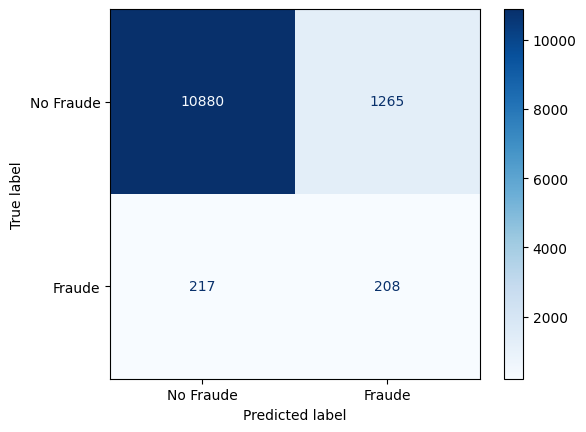

In [150]:
plt.figure(figsize=(10, 6))
cm = confusion_matrix(y_test,predicciones)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Fraude', 'Fraude'])
disp.plot(cmap=plt.cm.Blues)
plt.savefig('matrix')
plt.show()

In [151]:
precision_positiva = metrics.precision_score(y_test, predicciones, pos_label=0)
precision_negativa = metrics.precision_score(y_test, predicciones, pos_label=1)
print("Precisión No Fraude: %.2f" % ((precision_positiva)))
print("Precisión Fraude: %.2f" % ((precision_negativa)))

Precisión No Fraude: 0.98
Precisión Fraude: 0.14


In [152]:
recall_sensibilidad = metrics.recall_score(y_test, predicciones, pos_label=0)
recall_sensibilidad_negativa= metrics.recall_score(y_test, predicciones, pos_label=1)
print("Sensibilidad de No fraude: %.2f" % ((recall_sensibilidad)))
print("Sensibilidad de Fraude: %.2f" % ((recall_sensibilidad_negativa)))

Sensibilidad de No fraude: 0.90
Sensibilidad de Fraude: 0.49


In [153]:
f1_positivo = metrics.f1_score(y_test, predicciones, pos_label=0)
f1_negativo = metrics.f1_score(y_test, predicciones, pos_label=1)
print("F1 No Fraude: %.2f" % ((f1_positivo)))
print("F1 Fraude: %.2f" % ((f1_negativo)))

F1 No Fraude: 0.94
F1 Fraude: 0.22


In [154]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
print("Reporte de Clasificación:")
print(classification_report(y_test, predicciones))

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94     12145
           1       0.14      0.49      0.22       425

    accuracy                           0.88     12570
   macro avg       0.56      0.69      0.58     12570
weighted avg       0.95      0.88      0.91     12570



**Conclusión:**


Observamos que la precisión para la clase "No Fraude" es de del 97%, indicando una confianza considerable al acusar a un cliente de fraude. Esta alta precisión sugiere que el riesgo de clasificar erróneamente una transacción legítima como fraude es mínimo. Sin embargo, es esencial señalar que la precisión para detectar fraudes es del 68%, un valor que podría considerarse relativamente bajo al determinar la autenticidad de una transacción sospechosa.

Notamos también una destacada sensibilidad en la detección de "No Fraude". Este fenómeno podría ser atribuible al desbalance de clases, donde el modelo podría inclinarse hacia la predicción de la clase mayoritaria. Esta observación subraya la necesidad de abordar adecuadamente el desbalance para mejorar la capacidad del modelo para identificar instancias de "Fraude".

Al examinar los valores F1, encontramos que el 98% para "No Fraude" refleja un equilibrio efectivo entre precisión y sensibilidad en esa clase. No obstante, el valor F1 del 28% para "Fraude" destaca una oportunidad para mejorar la capacidad del modelo en la identificación precisa de transacciones fraudulentas, sin comprometer significativamente la tasa de falsos positivos.





### 9.7 Uso ROC

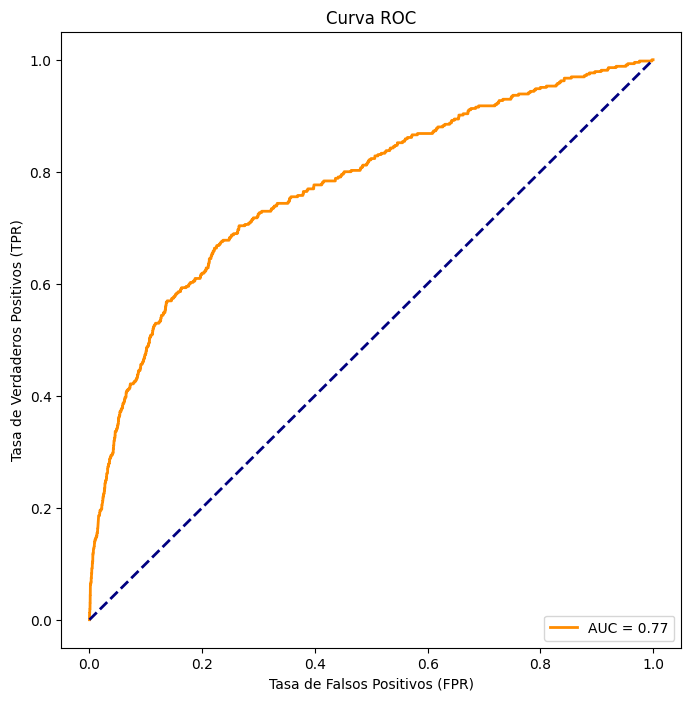

In [155]:
y_probs = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_roc = roc_auc_score(y_test, y_probs)

# Graficar la curva ROC
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc_roc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()


En tu caso, un AUC de 0.79 indica que el modelo tiene un rendimiento moderado para distinguir entre las clases "No Faude" y "Fraude".No es excelente, pero tampoco es aleatorio

### 9.8 Características Importantes

In [156]:
importancia_df = pd.DataFrame({
    'Características': X_train.columns,
    'importancia': rf_model.feature_importances_
}).sort_values('importancia', ascending=False)
importancia_df.head(10)

Características  importancia
1343              ProductCD_W     0.139007
1              TransactionAmt     0.091457
0               TransactionDT     0.086655
56                addr1_299.0     0.083917
1359  P_emaildomain_gmail.com     0.034455
1396  P_emaildomain_yahoo.com     0.031256
66                addr1_325.0     0.021490
50                addr1_264.0     0.017671
32                addr1_204.0     0.017182
147                 dist1_1.0     0.016559

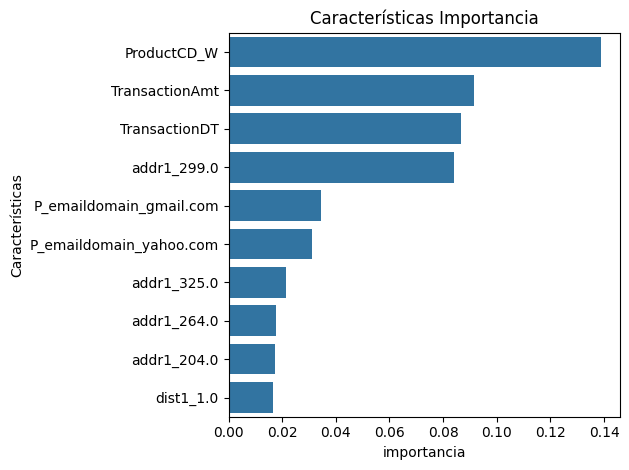

In [157]:
plt.title('Características Importancia')
sns.barplot(data=importancia_df.head(10), x='importancia', y='Características');
plt.tight_layout()
plt.savefig('caracteristicas.png')

In [158]:
df_train_R1.head()

isFraud  TransactionDT  TransactionAmt ProductCD  addr1 addr2 dist1  \
542017        0       14306465            47.0         W  231.0  87.0   0.0   
149838        0        3091325            49.0         W  327.0  87.0  24.0   
286886        0        7058975            49.0         W  327.0  87.0  11.0   
269769        0        6546429            39.0         W  204.0  87.0   5.0   
290004        0        7148883            59.0         W  204.0  87.0   0.0   

       P_emaildomain  
542017     gmail.com  
149838     gmail.com  
286886     yahoo.com  
269769      live.com  
290004     gmail.com

El análisis revela que los atributos más importantes para detectar fraude en las transacciones de compra son el tiempo y el método de pago. Además, la ubicación geográfica del comprador y la distancia también son factores relevantes. Estos hallazgos subrayan la importancia de considerar una variedad de atributos para mejorar la detección y prevención del fraude en las transacciones comerciales.

## Uso del xbboost

Primera prueba del uso xbgboost, en ella utilizaremos validación cruzada,

In [162]:
# Importar xgboost
import xgboost as xgb

In [163]:
# Crear el DMatrix con todos los datos
churn_dmatrix = xgb.DMatrix(data=X_train_balanced, label=y_train_balanced )

In [164]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'eta': 0.3,
    'eval_metric': 'auc'
}

cv_results = xgb.cv(dtrain=churn_dmatrix, params=params,
                    nfold=3, num_boost_round=5,
                    metrics="auc", as_pandas=True, seed=123)
print(cv_results)
print(f"AUC: {cv_results['test-auc-mean'].iloc[-1]:.6f}")

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.796294       0.003011       0.793363      0.003649
1        0.815891       0.008306       0.813949      0.007970
2        0.822758       0.003421       0.821260      0.003526
3        0.840778       0.000695       0.839091      0.000978
4        0.850113       0.001456       0.847968      0.002312
AUC: 0.847968


Se logró un mejor valor de AUC con XGBoost. Ajustando los hiperparámetros, el mejor valor de AUC obtenido con Random Forest fue 0.79, mientras que con XGBoost se alcanzó un AUC de 0.84, indicando que la clasificación binaria es mucho más precisa con XGBoost.